# PART 4: MODELING

This notebook will conduct any remaining pre-processing steps and will execute unsupervised and supervised ML techniques on the players' statistical data.

---

In [1]:
# Data Management
import numpy as np
import pandas as pd
from prettytable import PrettyTable

# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, PrecisionRecallCurve, ClassPredictionError, DiscriminationThreshold
from yellowbrick.model_selection import FeatureImportances, LearningCurve, ValidationCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.target import ClassBalance

# Modeling & Metrics
import statsmodels.api as sm
import xgboost as xgb
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_regression, mutual_info_regression, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from scipy.stats import ttest_ind
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.cluster import AgglomerativeClustering, Birch, KMeans, MiniBatchKMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, calinski_harabasz_score, completeness_score, davies_bouldin_score, homogeneity_score, rand_score, silhouette_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, plot_roc_curve, RocCurveDisplay, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, explained_variance_score 
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree


# Utils
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display, HTML
import random
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('default')  # sub 'dark_background'

## 4A: Setup

**Objective:** Load the processed player statistics and lineup data into local dataframes.

---

In [2]:
player_df = pd.read_csv('./cln_comprehensive_stats.csv', sep=',', header=0, index_col=None)
player_df

PLAYER     H  POS TEAM  GP   MIN  POSS  %FGA  %3PA  \
0            Precious Achiuwa  80.0    F  TOR  71  1686  3330  18.4  13.3   
1                Steven Adams  83.0    C  MEM  74  1953  4054   9.8   0.1   
2                 Bam Adebayo  81.0  F-C  MIA  55  1792  3630  23.1   0.5   
3           LaMarcus Aldridge  83.0  F-C  BKN  47  1050  2213  23.8   7.4   
4    Nickeil Alexander-Walker  77.0    G  UTA  64  1460  3004  25.5  31.5   
..                        ...   ...  ...  ...  ..   ...   ...   ...   ...   
235       Robert Williams III  81.0  F-C  BOS  61  1804  3666  11.2   0.1   
236            Christian Wood  81.0    F  HOU  68  2094  4443  23.7  20.1   
237              Delon Wright  77.0    G  ATL  75  1409  2902  10.6  11.0   
238                Trae Young  73.0    G  ATL  74  2582  5405  31.1  31.9   
239               Ivica Zubac  84.0    C  LAC  74  1804  3686  14.5   0.0   

     %FTA  ...  %opp_pnrrm_FGA  opp_pnrrm_FG%  %opp_postup_FGA  \
0    16.6  ...         0.01090          40.62          0.00987   
1    21.8  ...         0.02078          41.33          0.00776   
2    40.0  ...         0.00619          36.84          0.01009   
3    21.4  ...         0.01296          30.77          0.01196   
4    16.4  ...         0.00422          45.45          0.00422   
..    ...  ...             ...            ...              ...   
235  12.2  ...         0.01000          24.24          0.00818   
236  31.2  ...         0.00932          27.03          0.01562   
237   9.1  ...         0.00510          23.08          0.00510   
238  43.7  ...         0.00621          36.67          0.00725   
239  33.2  ...         0.01456          61.22          0.00951   

     opp_postup_FG%  %opp_spotup_FGA  opp_spotup_FG%  %opp_handoff_FGA  \
0             41.38          0.05414           37.11           0.00000   
1             57.14          0.04404           33.96           0.00305   
2             48.39          0.04461           40.88           0.00261   
3             41.67          0.04038           40.74           0.00000   
4             72.73          0.05138           43.28           0.01265   
..              ...              ...             ...               ...   
235           37.04          0.06424           30.66           0.00424   
236           53.23          0.05368           40.38           0.00554   
237           53.85          0.05135           45.80           0.01490   
238           48.57          0.04203           40.39           0.01325   
239           25.00          0.05407           46.70           0.00000   

     opp_handoff_FG%  %opp_offscrn_FGA  opp_offscrn_FG%  
0                NaN           0.00340            40.00  
1              27.27           0.00360            53.85  
2              50.00           0.00423            23.08  
3                NaN           0.00000              NaN  
4              27.27           0.01150            26.67  
..               ...               ...              ...  
235             7.14           0.00576            31.58  
236            50.00           0.00680            37.04  
237            34.21           0.01215            35.48  
238            45.31           0.00973            48.94  
239              NaN           0.00208            71.43  

[240 rows x 102 columns]

In [3]:
lineup_df = pd.read_csv('./cln_lineup_stats.csv', sep=',', header=0, index_col=None)
# lineup_df

## 4B: Unsupervised-Modeling Pre-Requisites

**Objective:** Execute any necessary pre-processing steps and pre-requisite unsupervised ML techniques to prepare for modeling.

---

#### Filter out attributes based on EDA from Part 3: 

In [4]:
player_df = player_df[[
    'PLAYER', 'POS', '%FGA', '%3PA', '%REB', '%AST', '%BLKA', '%PFD',  # Utils & Usage

    'PassesMade/POSS', 'ScreenAssists/POSS', 'ASTAdj/POSS',  # Passing stats

    'PTS/POSS', '2P%', '3P%', 'FT%', '%PTSFT',  # Base scoring info

    '%RA_FGA', '%PT_nonRA_FGA', '%MR_FGA', '%cns_2FGA', '%pullup_2FGA', '2FGM%UAST',  # 2-Pt scoring zones & styles

    '%Corner3_FGA', '%ATB3_FGA', '%cns_3PA', '%pullup_3PA', '3FGM%UAST',  # 3-Pt scoring zones & styles

    '%dr_1_2_fga', '%trsn_FGA', '%iso_FGA', '%pnrbh_FGA', '%pnrrm_FGA', '%postup_FGA',  # Offensive-style
    '%spotup_FGA', '%handoff_FGA', '%cuts_FGA', '%offscrn_FGA', '%putbk_FGA', 

    'DRIVES/POSS', 'drives_PASS%','Dist. Miles Off/POSS', 'Avg Sec PerTouch', 'ElbowTouches/POSS', 'PostUps/POSS', 'PaintTouches/POSS',  # Offensive activity 
    'PTS PerElbow Touch', 'PTS PerPost Touch', 'PTS PerPaint Touch',  # Touch-efficiency 

    'ContestedREB%', 'AVG REBDistance', 'Box Outs/MIN',  # Rebound-related stats

    'BLK/MIN', 'Deflections/MIN', 'Loose BallsRecovered/MIN', 'ChargesDrawn/MIN',  # Defensive activity
    'Contested2PT Shots/MIN', 'Contested3PT Shots/MIN', 'OppTOV/MIN', 'OppPF/MIN', 'OppFTA/MIN',

    'Opp2P%', '%opp_RA_FGA', 'opp_RA_FG%', '%opp_PT_nonRA_FGA', 'opp_PT_nonRA_FG%', '%opp_MR_FGA', 'opp_MR_FG%',   # Opponent 2-Pt efficiency
    'Opp3P%', '%opp_Corner3_FGA', 'opp_Corner3_FG%', '%opp_ATB3_FGA', 'opp_ATB3_FG%',  # Opponent 3-Pt efficiency

    '%opp_iso_FGA', 'opp_iso_FG%', '%opp_pnrbh_FGA', 'opp_pnrbh_FG%', '%opp_pnrrm_FGA', 'opp_pnrrm_FG%', '%opp_postup_FGA', 'opp_postup_FG%',  # Defended styles
    '%opp_spotup_FGA', 'opp_spotup_FG%', '%opp_handoff_FGA', 'opp_handoff_FG%', '%opp_offscrn_FGA', 'opp_offscrn_FG%'
]]

Features were further truncated based on findings in Part 3's exploratory analysis. This removes some of the redundant features not caught in the initial cleaning process and better prepares the dataset to yield more reliable modeling results. Player statistics info strategically employs a hybrid of offensive and defensive attributes, each broken down by style and effiency. These attributes were chosen to effectively distinguish between different players in an unsupervised model.

#### Stratify player statistics to prepare for clustering by position:

In [5]:
guards_df = player_df[player_df.POS == 'G'].drop(columns=['POS']).set_index('PLAYER').copy()
wings_df = player_df[player_df.POS == 'G-F'].drop(columns=['POS']).set_index('PLAYER').copy()
forwards_df = player_df[player_df.POS == 'F'].drop(columns=['POS']).set_index('PLAYER').copy()
bigs_df = player_df[player_df.POS == 'F-C'].drop(columns=['POS']).set_index('PLAYER').copy()

In [6]:
print(guards_df.shape)
print(wings_df.shape)
print(forwards_df.shape)
print(bigs_df.shape)

(98, 84)
(35, 84)
(62, 84)
(29, 84)


Players are broken down by position in order to execute clustering algorithms. This was done for several reasons. One, there is an inherent bias during lineup selection that isn't exactly captured by modeling -- lineup position designations. Clustering, as a feature engineering step, generates attributes that capture intra-position differences better in order to build any model solely based on player role. Another advantage with this strategy is to be able to handle missing values specific for the position (i.e., postup-defense is not relevant for guards and therefore if the attribute has missing values, the column can be dropped). The end-user, at the end of the day, will choose lineups based on the traditional G/F/C designations to forecast their performance and therefore this made the most practical sense to employ.

#### Handle missing values:

In [7]:
def missing_val_counter(large_df, df_name):
    """Examines input dataframe's attributes for missing values and outputs dictionary with non-zero counts."""
    
    missing_dict = {}
     
    for col in large_df.columns:
        missing = large_df[col].isnull().sum()
        # Only include if attribute has missing values
        if missing != 0:  
            missing_dict[col] = missing
    
    print(df_name, ': ', missing_dict)
    return 

missing_val_counter(guards_df, 'Guards')
missing_val_counter(wings_df, 'Wings')
missing_val_counter(forwards_df, 'Forwards')
missing_val_counter(bigs_df, 'Bigs')

Guards :  {'opp_pnrrm_FG%': 16, 'opp_postup_FG%': 4, 'opp_offscrn_FG%': 1}
Wings :  {'opp_pnrrm_FG%': 5, 'opp_postup_FG%': 1}
Forwards :  {'opp_iso_FG%': 1, 'opp_pnrbh_FG%': 1, 'opp_pnrrm_FG%': 3, 'opp_postup_FG%': 2, 'opp_spotup_FG%': 1, 'opp_handoff_FG%': 6, 'opp_offscrn_FG%': 5}
Bigs :  {'3P%': 1, 'opp_pnrbh_FG%': 8, 'opp_pnrrm_FG%': 2, 'opp_handoff_FG%': 9, 'opp_offscrn_FG%': 11}


In [8]:
# Drop attribute with many missing values
guards_df = guards_df.drop(columns=['opp_pnrrm_FG%'])
bigs_df = bigs_df.drop(columns=['opp_pnrbh_FG%', 'opp_handoff_FG%', 'opp_offscrn_FG%'])

# Impute few missing records with the mean for the position
guards_df['opp_postup_FG%'] = guards_df['opp_postup_FG%'].fillna(guards_df['opp_postup_FG%'].mean())
guards_df['opp_offscrn_FG%'] = guards_df['opp_offscrn_FG%'].fillna(guards_df['opp_offscrn_FG%'].mean())
wings_df['opp_pnrrm_FG%'] = wings_df['opp_pnrrm_FG%'].fillna(wings_df['opp_pnrrm_FG%'].mean())
wings_df['opp_postup_FG%'] = wings_df['opp_postup_FG%'].fillna(wings_df['opp_postup_FG%'].mean())
forwards_df['opp_iso_FG%'] = forwards_df['opp_iso_FG%'].fillna(forwards_df['opp_iso_FG%'].mean())
forwards_df['opp_pnrbh_FG%'] = forwards_df['opp_pnrbh_FG%'].fillna(forwards_df['opp_pnrbh_FG%'].mean())
forwards_df['opp_pnrrm_FG%'] = forwards_df['opp_pnrrm_FG%'].fillna(forwards_df['opp_pnrrm_FG%'].mean())
forwards_df['opp_postup_FG%'] = forwards_df['opp_postup_FG%'].fillna(forwards_df['opp_postup_FG%'].mean())
forwards_df['opp_spotup_FG%'] = forwards_df['opp_spotup_FG%'].fillna(forwards_df['opp_spotup_FG%'].mean())
forwards_df['opp_handoff_FG%'] = forwards_df['opp_handoff_FG%'].fillna(forwards_df['opp_handoff_FG%'].mean())
forwards_df['opp_offscrn_FG%'] = forwards_df['opp_offscrn_FG%'].fillna(forwards_df['opp_offscrn_FG%'].mean())
bigs_df['3P%'] = bigs_df['3P%'].fillna(bigs_df['3P%'].mean())
bigs_df['opp_pnrrm_FG%'] = bigs_df['opp_pnrrm_FG%'].fillna(bigs_df['opp_pnrrm_FG%'].mean())

Almost all the attributes with scattered missing values were defensive-related metrics. As the sub-datasets are small, the attributes were removed if there was a substantial amount of missing values. Otherwise, few records were imputed with the average for the position. As distance-based methods such as PCA or unsupervised ML techniques won't execute with null values, this was an important step to finish.

#### Scale the numeric features to prepare for PCA / Clustering:

In [9]:
# Scale the numeric attributes
scaler = RobustScaler()
guards_df[guards_df.columns.tolist()] = scaler.fit_transform(guards_df)
wings_df[wings_df.columns.tolist()] = scaler.fit_transform(wings_df)
forwards_df[forwards_df.columns.tolist()] = scaler.fit_transform(forwards_df)
bigs_df[bigs_df.columns.tolist()] = scaler.fit_transform(bigs_df)

Scaling is an important step before implementing a feature reduction technique such as PCA since it uses singular-value decomposition in its approach. To ensure that the ranges of the features aren't too different from each other, scaling the data before the projection of features into a lower-dimension can lead to better results with the PCA-feature dataset.

In this specific scenario, EDA showed potential outliers in a lot of the attributes. Therefore, `RobustScaler` was strategically chosen to account for the outliers, as it scales based on inter-quartile ranges instead of the min or max. 

#### Implement dimensionality-reduction through PCA techniques:

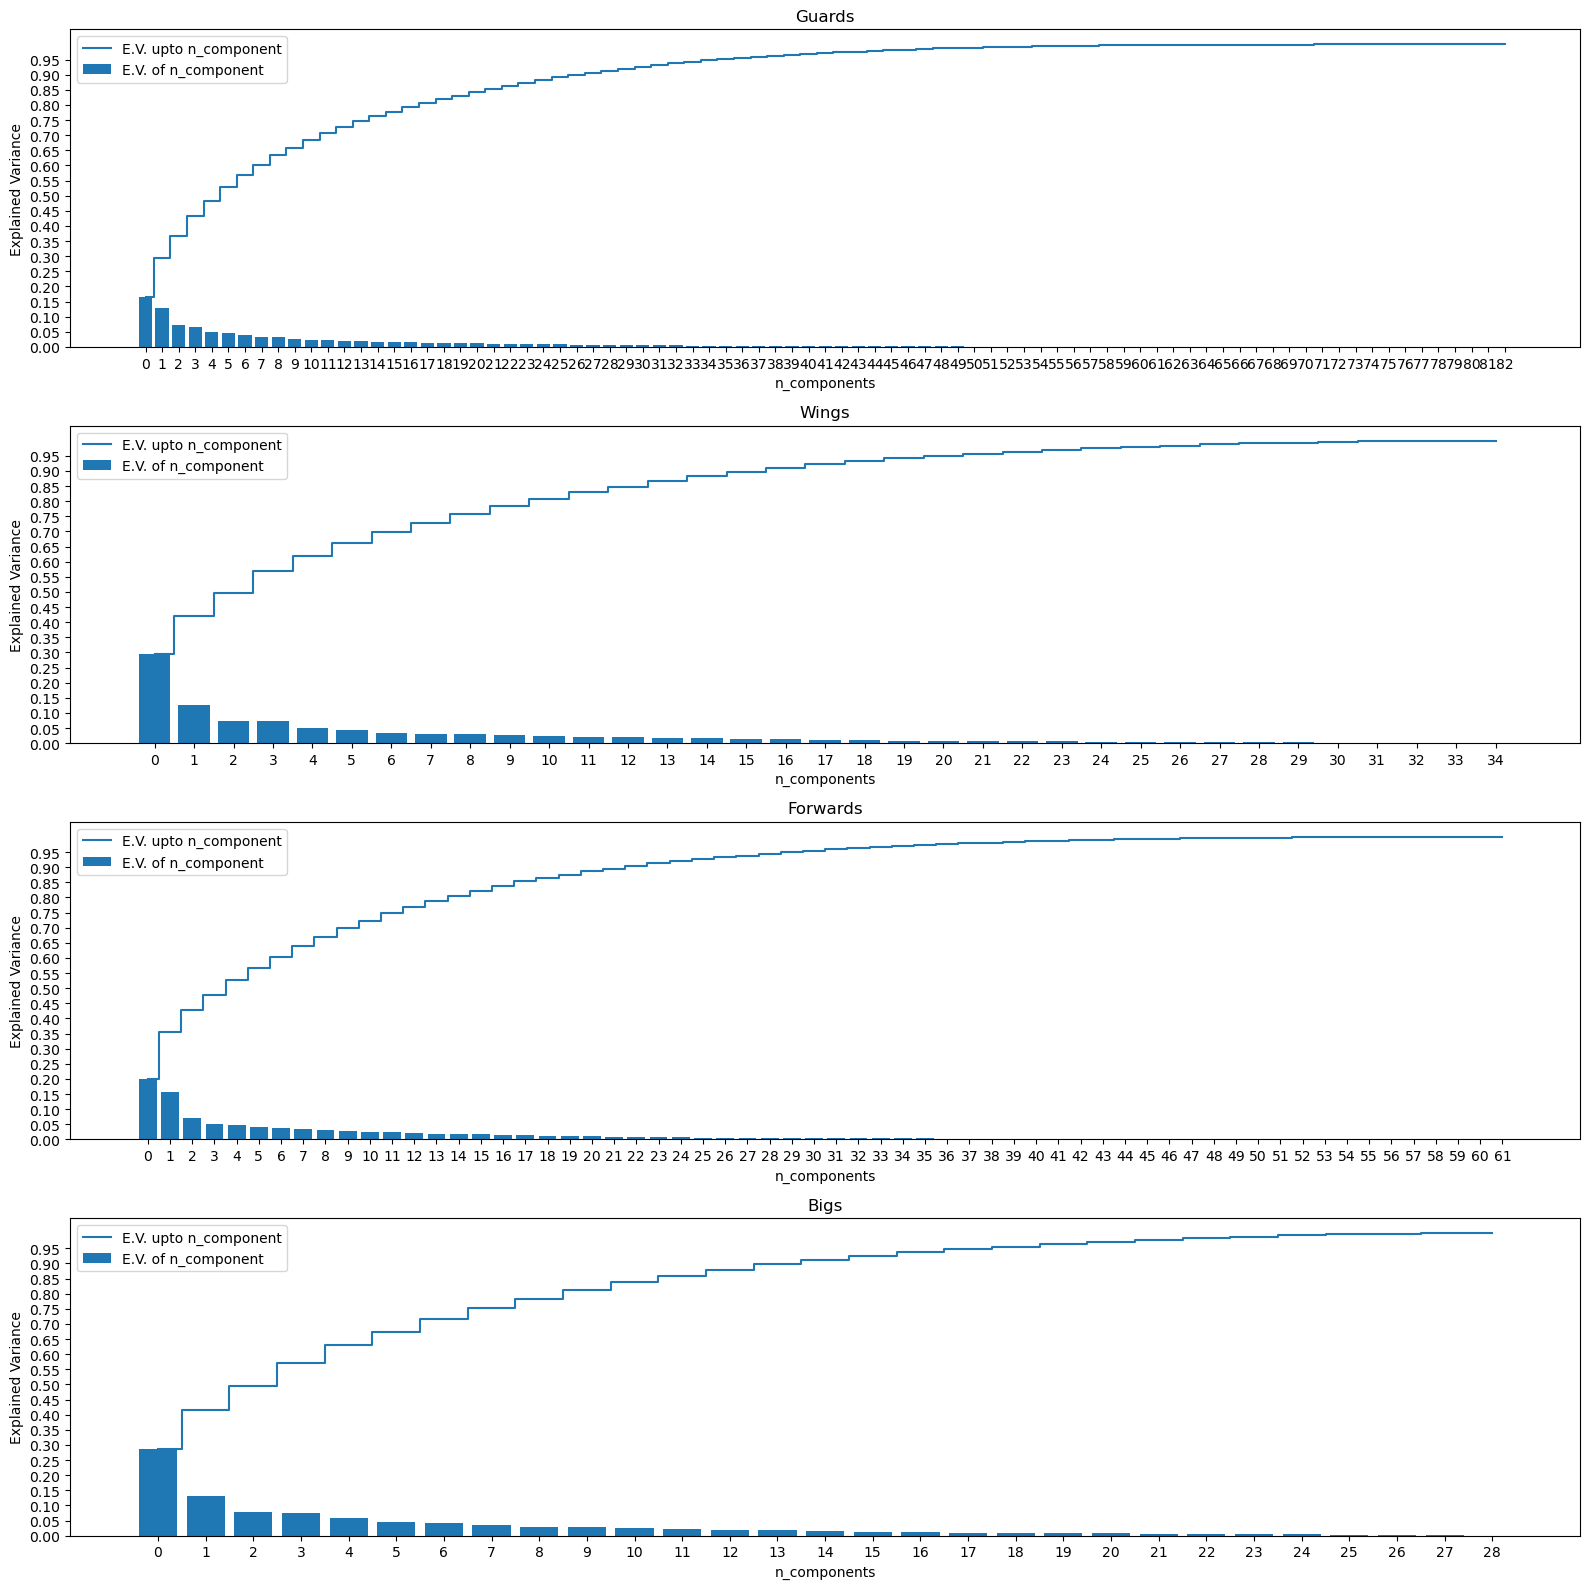

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(16, 16))

def plot_exp_var(df, ax, title):    
    """Explore explained variance to determine num. of PCA components"""
    
    # Create PCA set
    pca = PCA(n_components=min(len(df), len(df.columns)))
    pca.fit_transform(df.values)
    
    # Retrieve values to plot explained variance
    explained_vars = pca.explained_variance_ratio_
    cumulative_vars = np.cumsum(explained_vars)
    # print(cumulative_vars)
    
    ax.bar(range(0,len(explained_vars)), explained_vars, label='E.V. of n_component')
    ax.step(range(0,len(cumulative_vars)), cumulative_vars, where='mid', label='E.V. upto n_component')
    ax.set_xticks(np.arange(0, len(cumulative_vars), 1.0))
    ax.set_yticks(np.arange(0, 1, 0.05))
    ax.set_ylabel('Explained Variance')
    ax.set_xlabel('n_components')
    ax.set_title(title)
    ax.legend()
    return

plot_exp_var(guards_df, axs[0], 'Guards')
plot_exp_var(wings_df, axs[1], 'Wings')
plot_exp_var(forwards_df, axs[2], 'Forwards')
plot_exp_var(bigs_df, axs[3], 'Bigs')

plt.tight_layout()
plt.show()

In [11]:
# Set PCA component numbers based on atleast 70% EV
g, w, f, b = 12, 8, 11, 7  

# Create PCA set for guards
reduced_arr = PCA(n_components=g).fit_transform(guards_df.values)
pca_guards_df = pd.DataFrame(reduced_arr, columns=['PCA' + str(i) for i in range(g)])
pca_guards_df.index = guards_df.index.copy()

# Create PCA set for wings
reduced_arr = PCA(n_components=w).fit_transform(wings_df.values)
pca_wings_df = pd.DataFrame(reduced_arr, columns=['PCA' + str(i) for i in range(w)])
pca_wings_df.index = wings_df.index.copy()

# Create PCA set for forwards
reduced_arr = PCA(n_components=f).fit_transform(forwards_df.values)
pca_forwards_df = pd.DataFrame(reduced_arr, columns=['PCA' + str(i) for i in range(f)])
pca_forwards_df.index = forwards_df.index.copy()

# Create PCA set for bigs
reduced_arr = PCA(n_components=b).fit_transform(bigs_df.values)
pca_bigs_df = pd.DataFrame(reduced_arr, columns=['PCA' + str(i) for i in range(b)])
pca_bigs_df.index = bigs_df.index.copy()

Literature dictates that 70-80% explained variance is ideal when seeking out a number of principal components in any dimensionality-reduction effort. Therefore, 75% was chosen for this study, yielding 12, 8, 11, 7 respectively for the guards, wings, forwards and bigs. Using these number of principal components, the original attributes were engineered into new attributes to capture most of the information in the datasets with a reduced dimension. This would improve the efficiency of modeling algorithms and can potentially avoid overfitting.

Next, the newly created principal components are explored a bit to understand how the dimensionality-reduction technique is capturing the player statistics.

In [12]:
def interpret_pca(orig_df, pca_df, comp_num, title):
    """For a given dataset, plots the importances placed on each attribute for each principal component."""
    
    pca = PCA(n_components=comp_num)
    pca_df = pca.fit_transform(orig_df.values)

    pca_interp_df = pd.DataFrame(orig_df.columns.tolist(), columns=['attribute'])
    pca_interp_df[['PCA' + str(i) for i in range(comp_num)]] = pca.components_.T

    fig = make_subplots(rows=comp_num, cols=1, shared_xaxes=True, vertical_spacing=0.02)
    
    for comp in range(comp_num):
        fig.add_trace(go.Bar(name='PCA' + str(comp), x=pca_interp_df.attribute, y=pca_interp_df['PCA' + str(comp)]), row=comp+1, col=1)

    fig.update_layout(height=1600, width=1400, title_text=f'{title} Data: Eigenvalues of Corresponding Attributes based on PCA Component')
    fig.show()

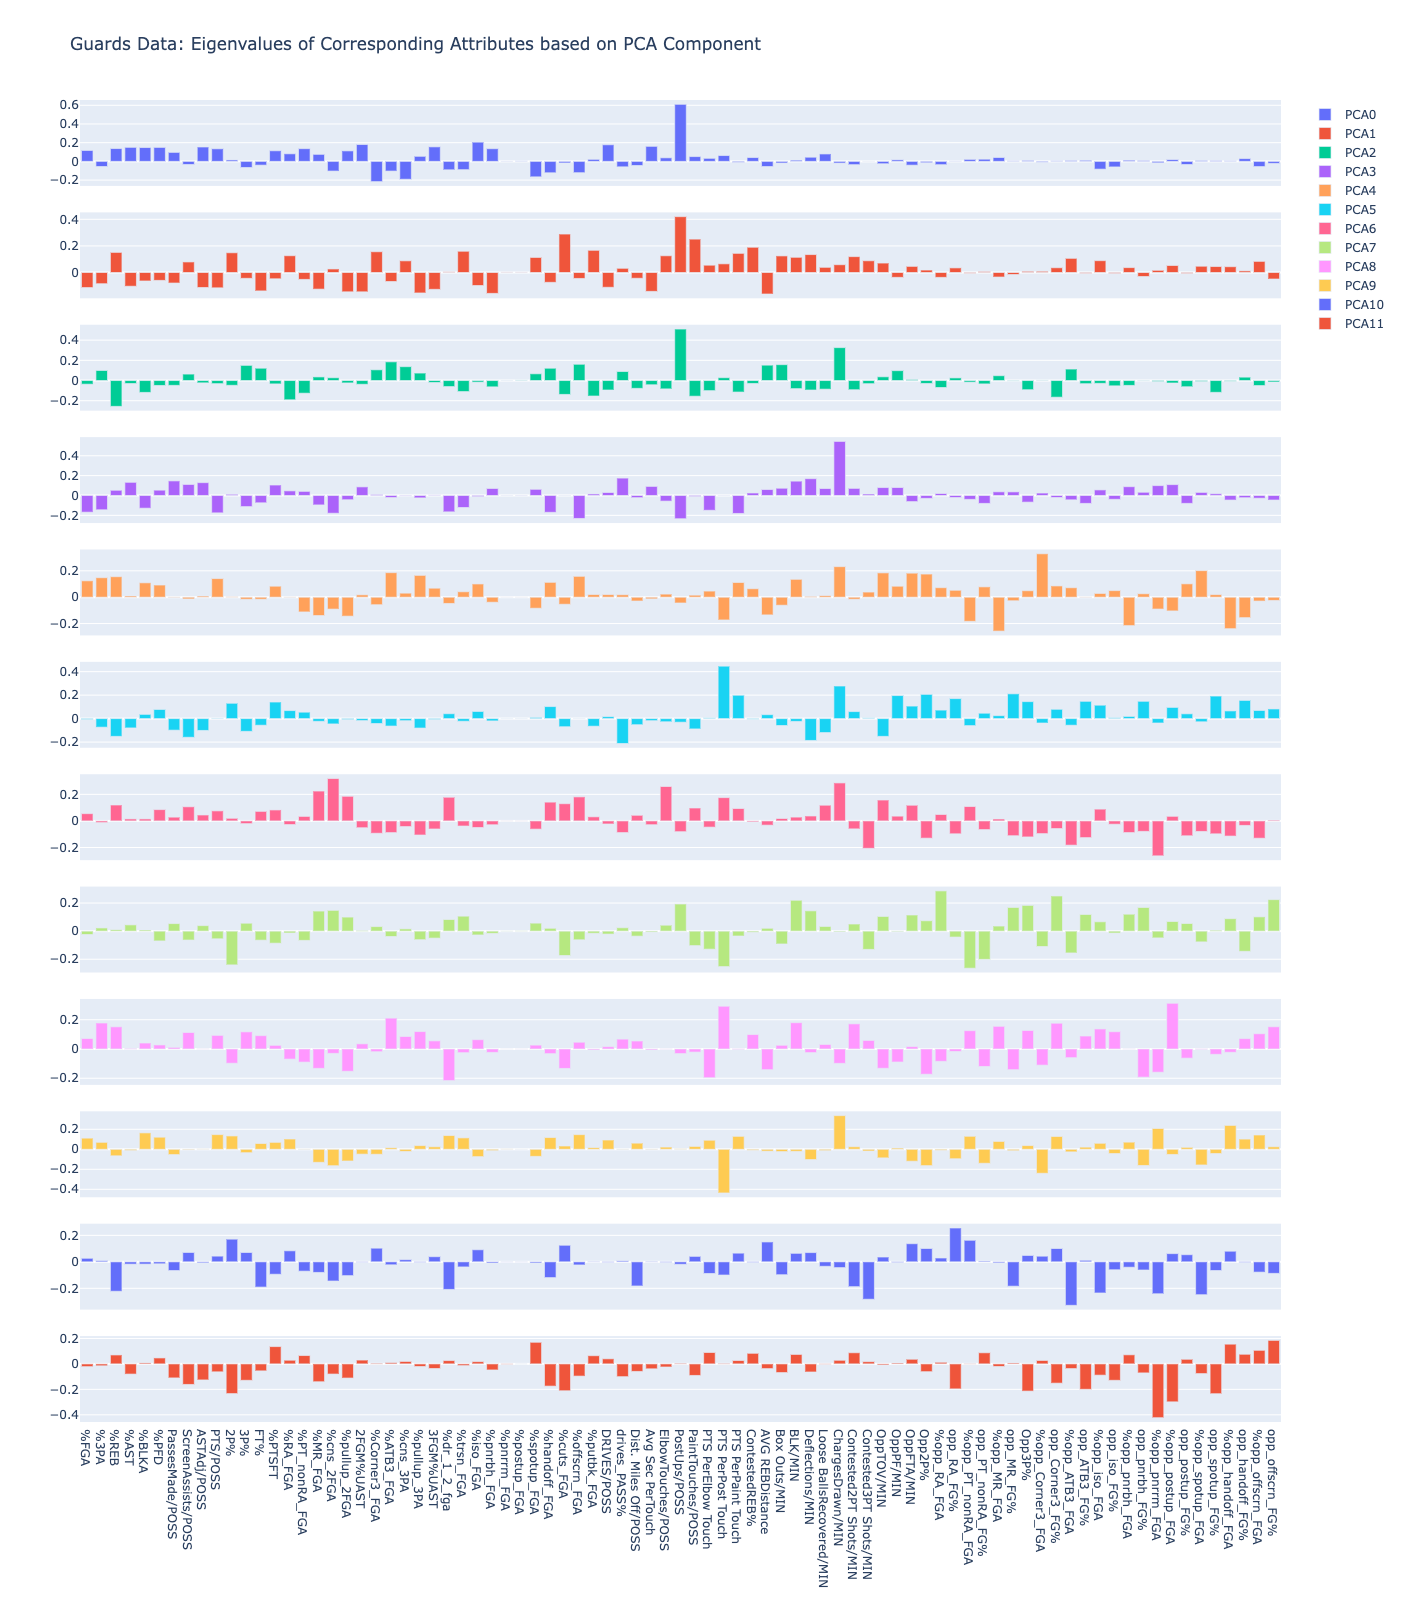

In [13]:
interpret_pca(guards_df, pca_guards_df, g, 'Guards')

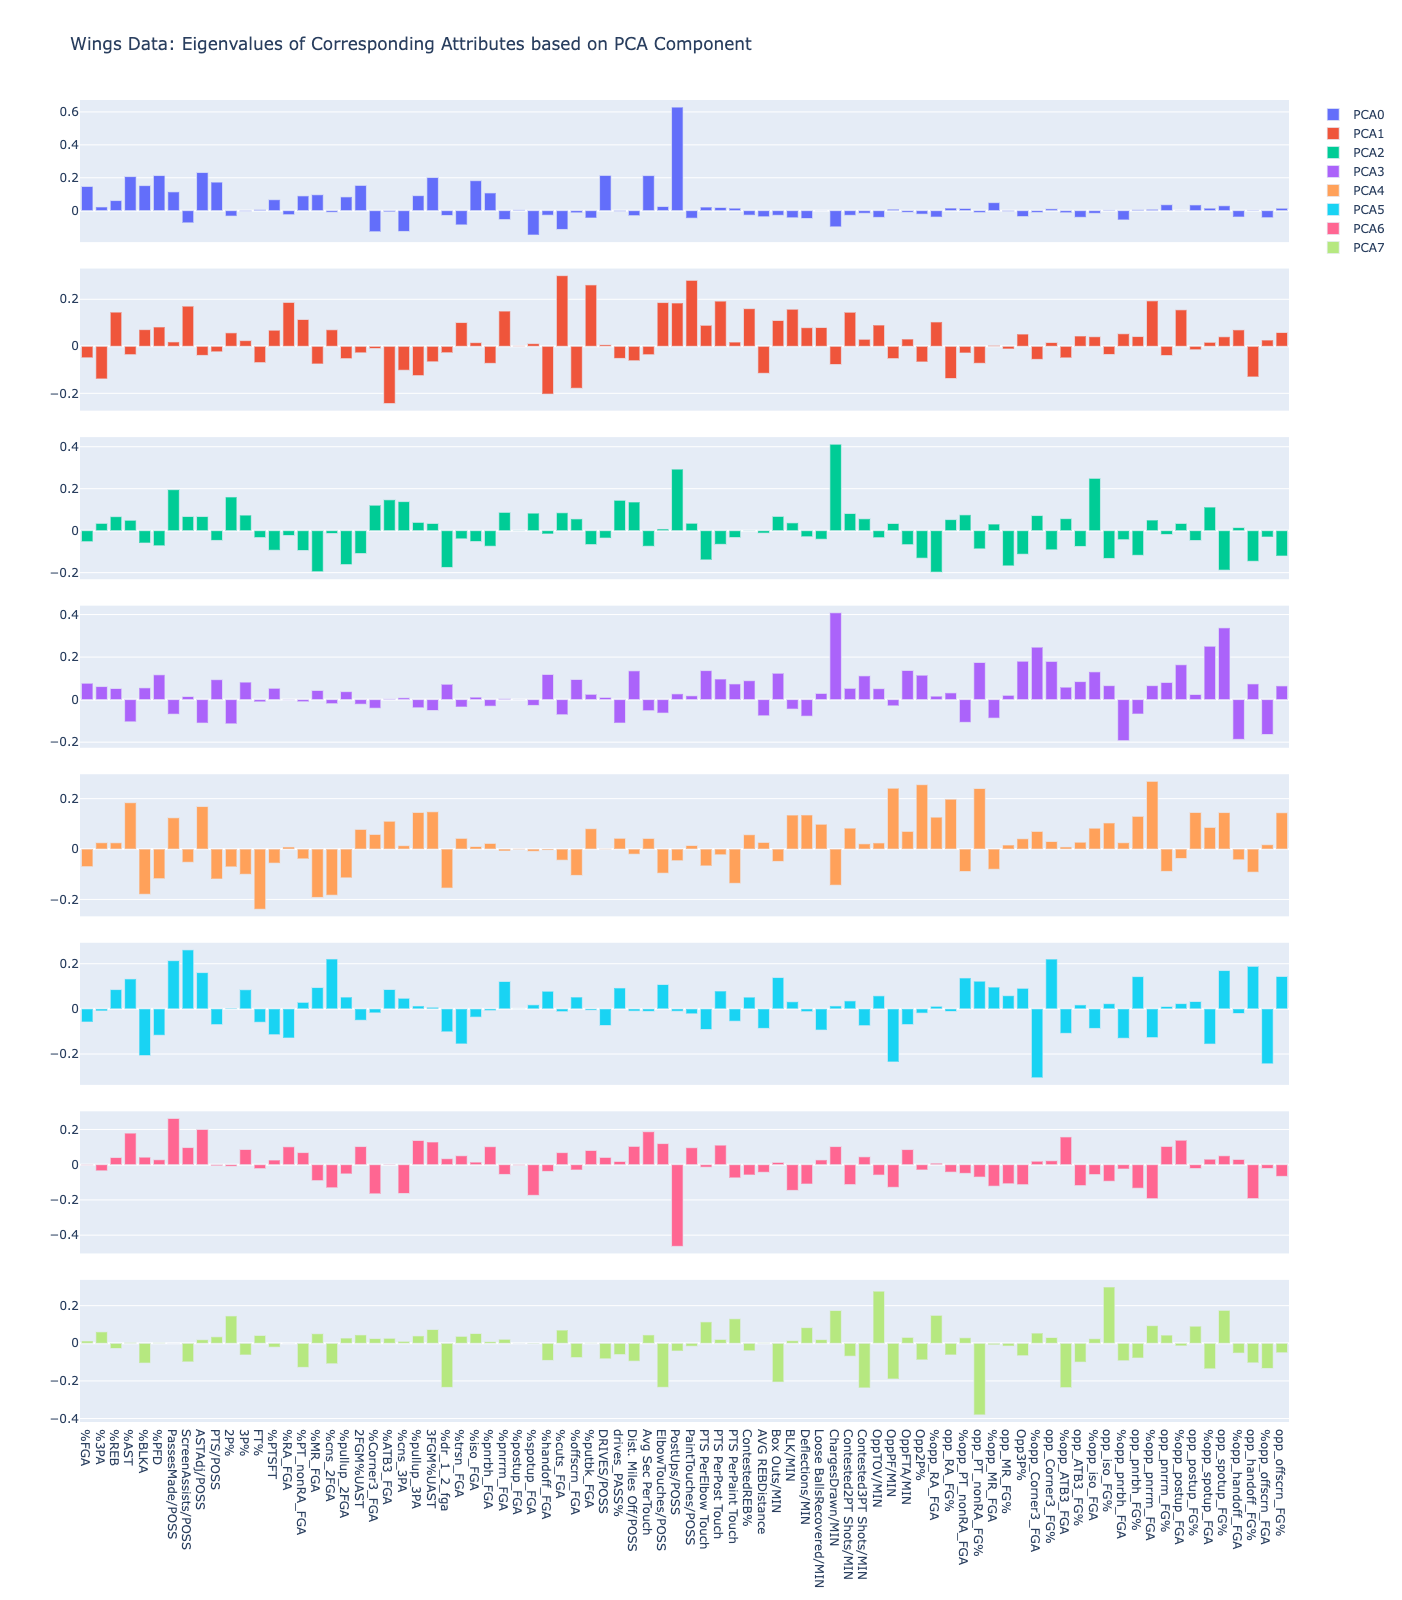

In [14]:
interpret_pca(wings_df, pca_wings_df, w, 'Wings')

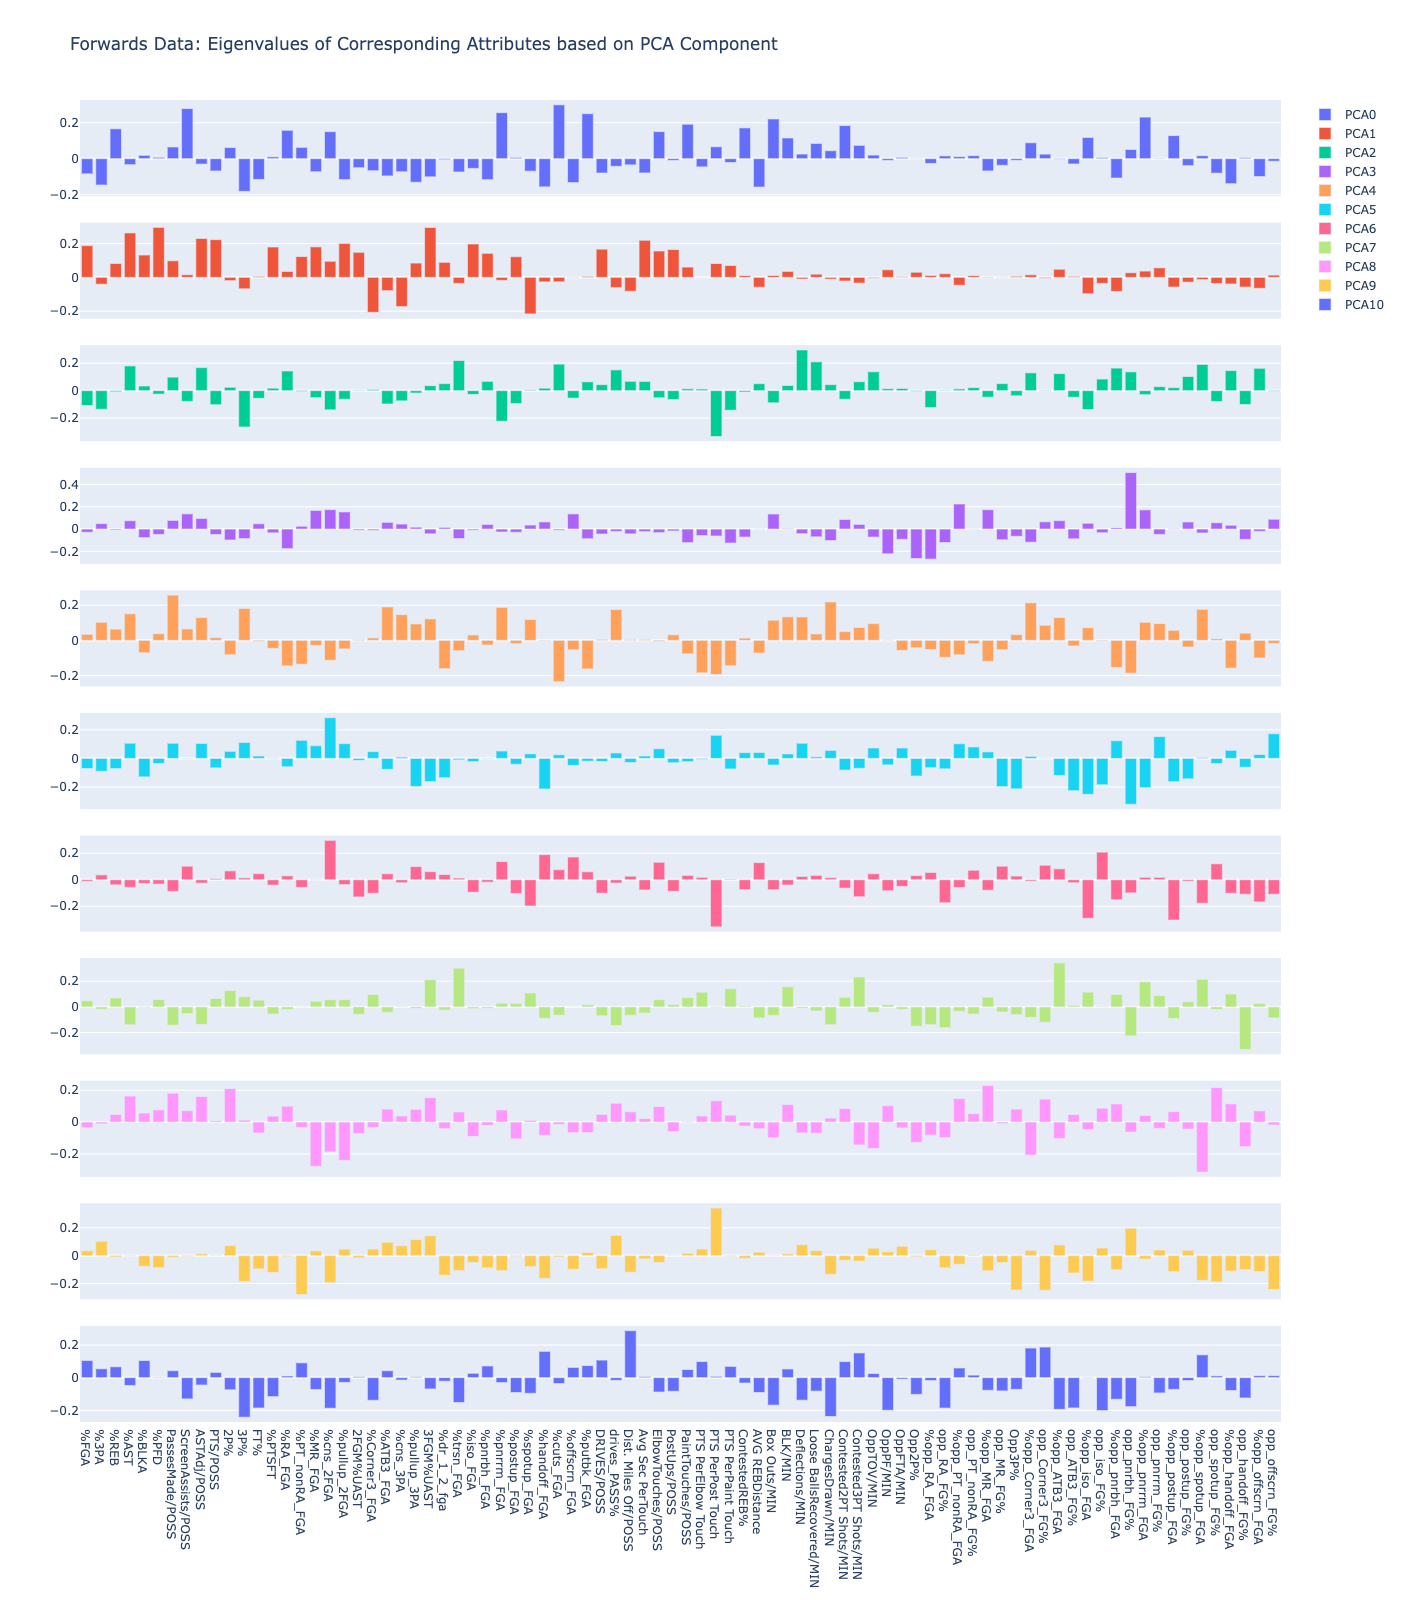

In [15]:
interpret_pca(forwards_df, pca_forwards_df, f, 'Forwards')

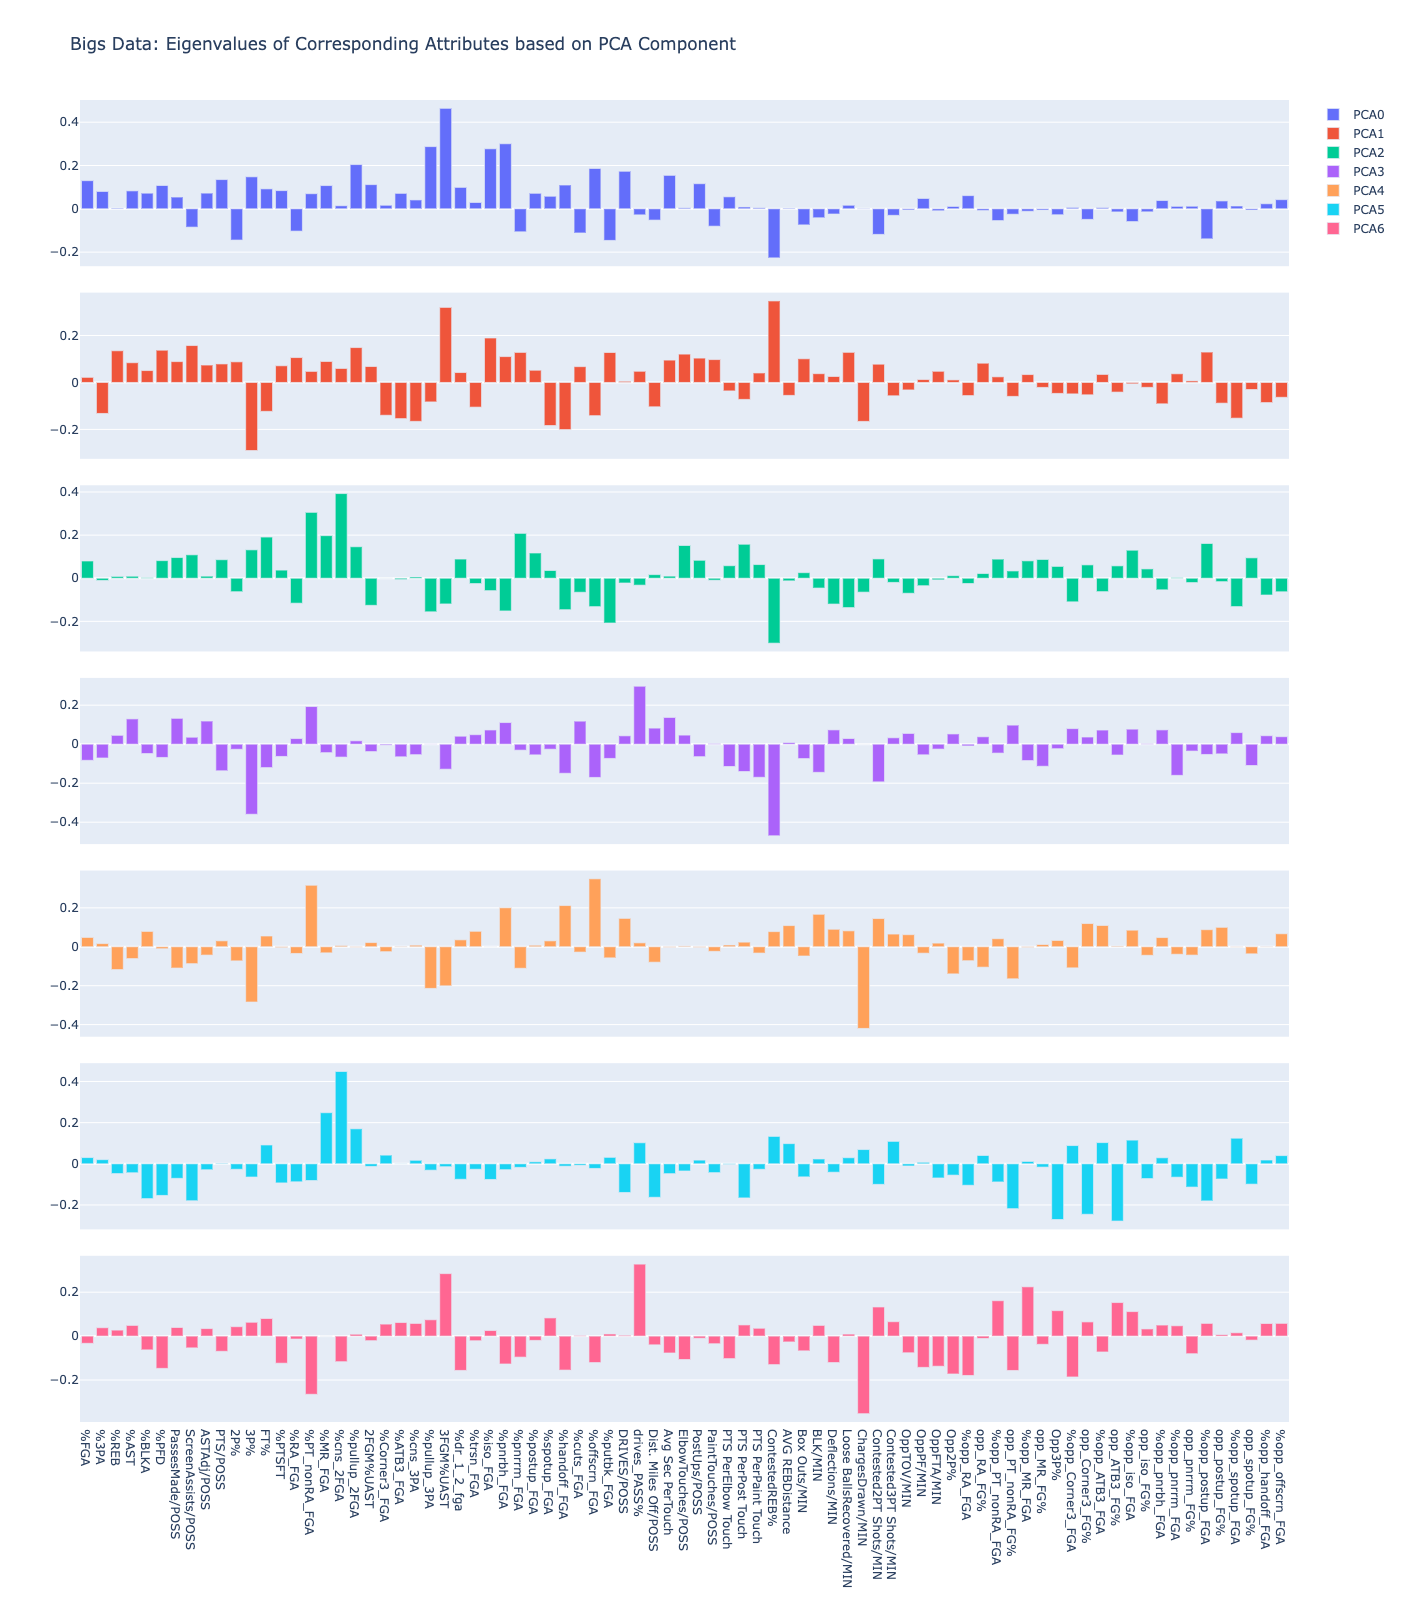

In [16]:
interpret_pca(bigs_df, pca_bigs_df, b, 'Bigs')

Through the charts above, for each positionary dataframe, we can visually observe how each attribute is rewarded/penalized for a specific principal component. On a high-level, it is immediately apparent how different PCA attributes have a unique subset of rewarded features to capture the data.

#### Implement exploratory steps to better inform the clustering process:

In [17]:
def plot_elbow_sil(df, rs=42):
    """Generates elbow & silhouette plots to better inform clustering decisions."""
    
    fig, axs = plt.subplots(2, 3, figsize=(18,  8))
    
    # Elbow plots with relevant metrics
    elbow_plot = KElbowVisualizer(KMeans(random_state=rs), k=(1, 10), metric='distortion', ax=axs[0][0]).fit(df).finalize()
    elbow_plot = KElbowVisualizer(KMeans(random_state=rs), k=(2, 10), metric='silhouette', ax=axs[0][1]).fit(df).finalize()
    elbow_plot = KElbowVisualizer(KMeans(random_state=rs), k=(2, 10), metric='calinski_harabasz', ax=axs[0][2]).fit(df).finalize()

    # Silhouette plots (2-4 clusters) for deeper examination
    sil_plot2 = SilhouetteVisualizer(KMeans(2, random_state=rs), ax=axs[1][0]).fit(df).finalize()
    sil_plot3 = SilhouetteVisualizer(KMeans(3, random_state=rs), ax=axs[1][1]).fit(df).finalize()
    sil_plot4 = SilhouetteVisualizer(KMeans(4, random_state=rs), ax=axs[1][2]).fit(df).finalize()
    
    plt.tight_layout()
    plt.show()
    return  

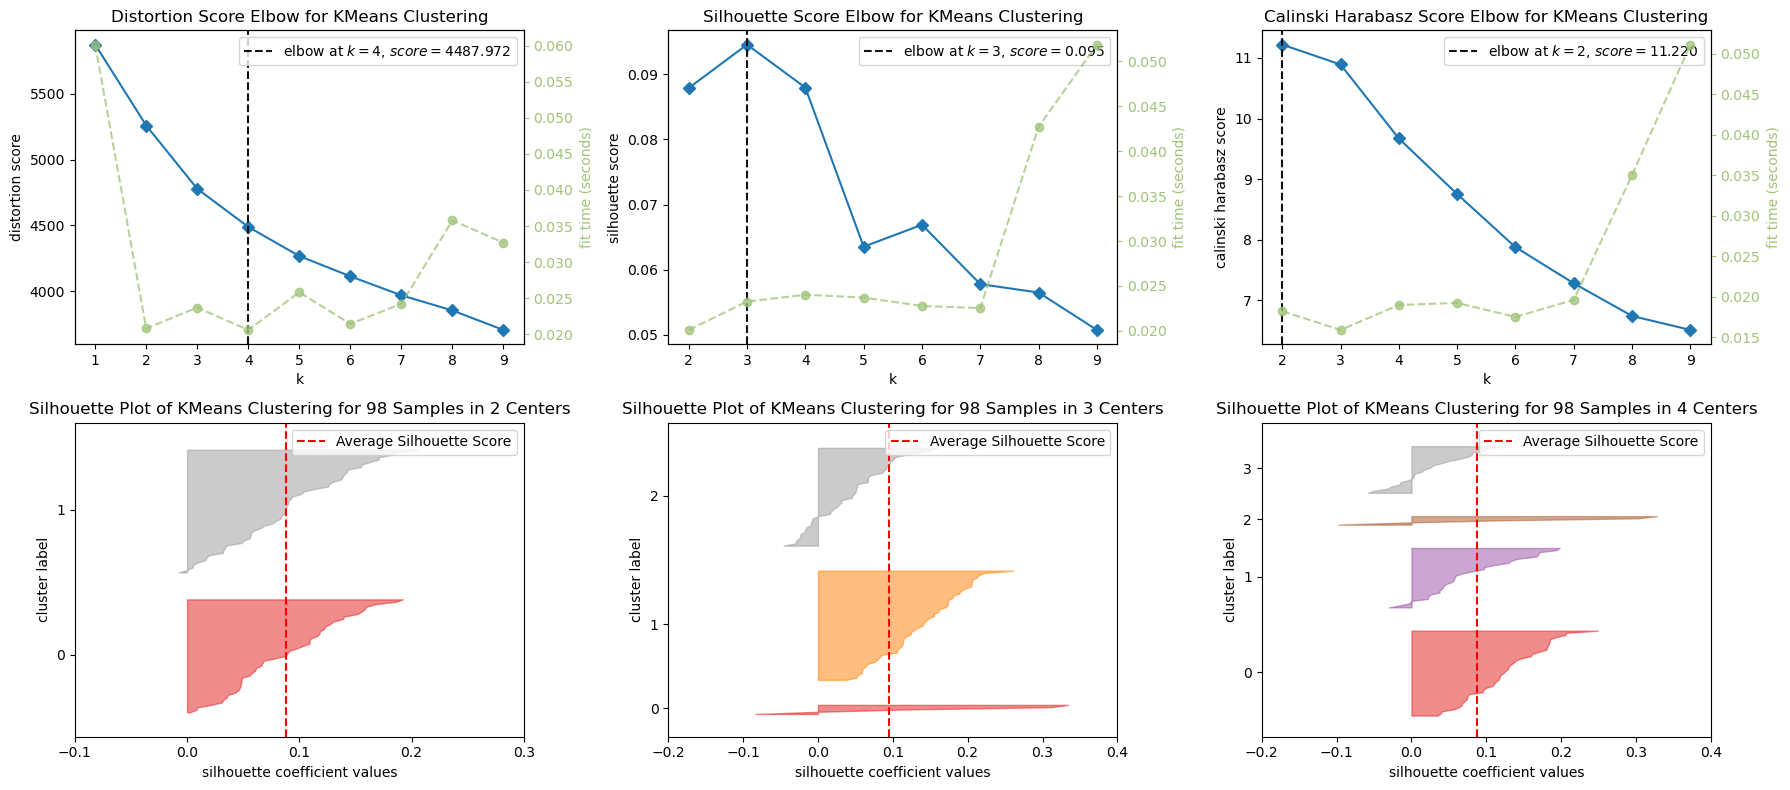

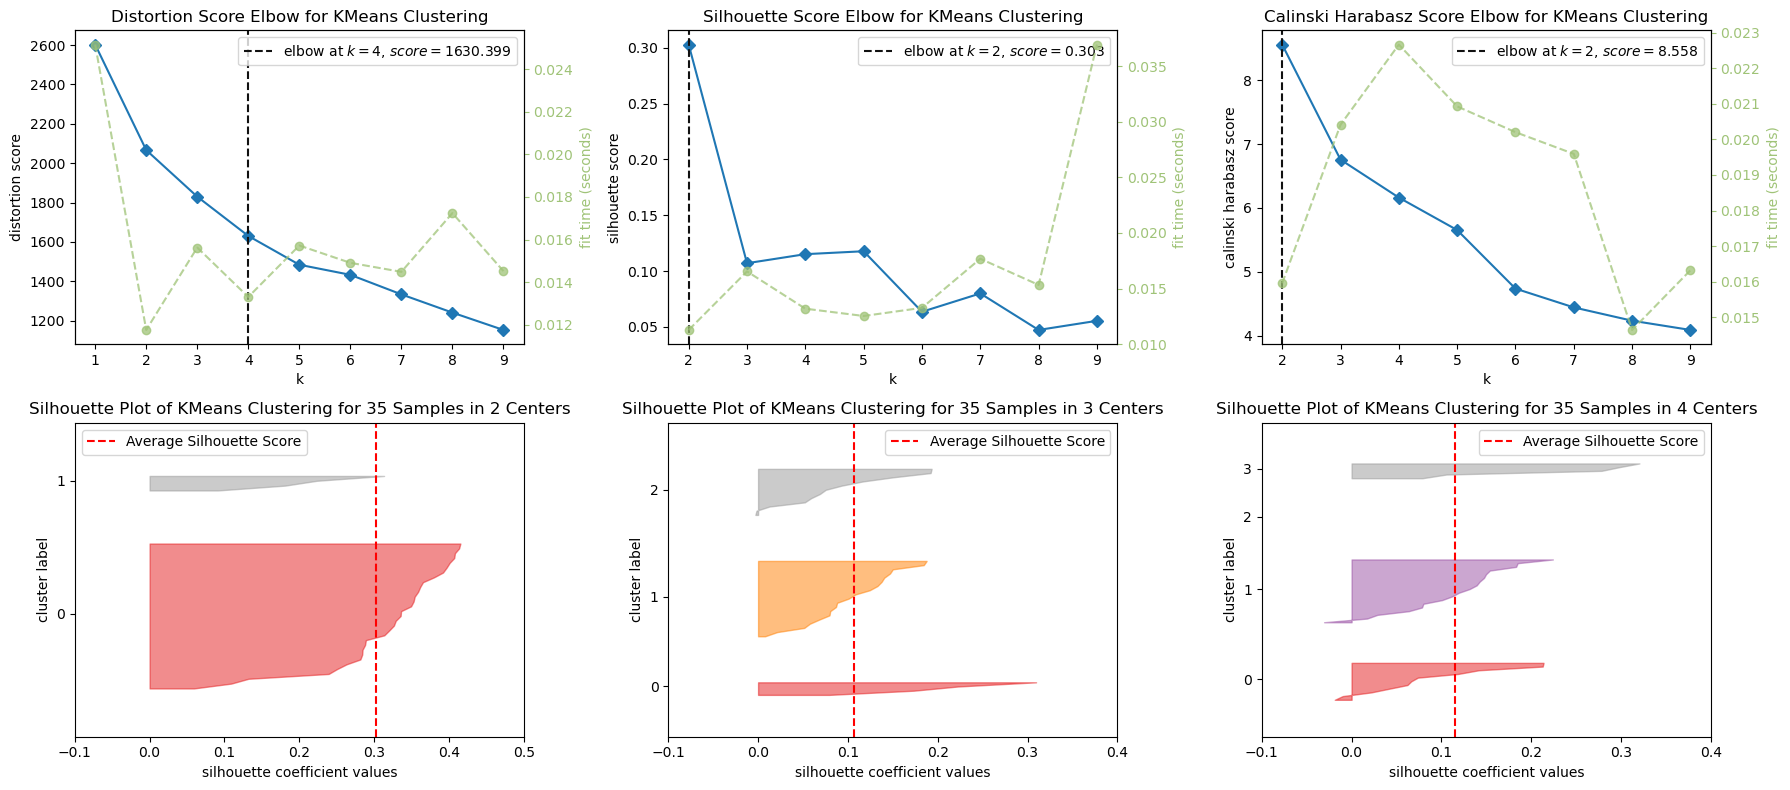

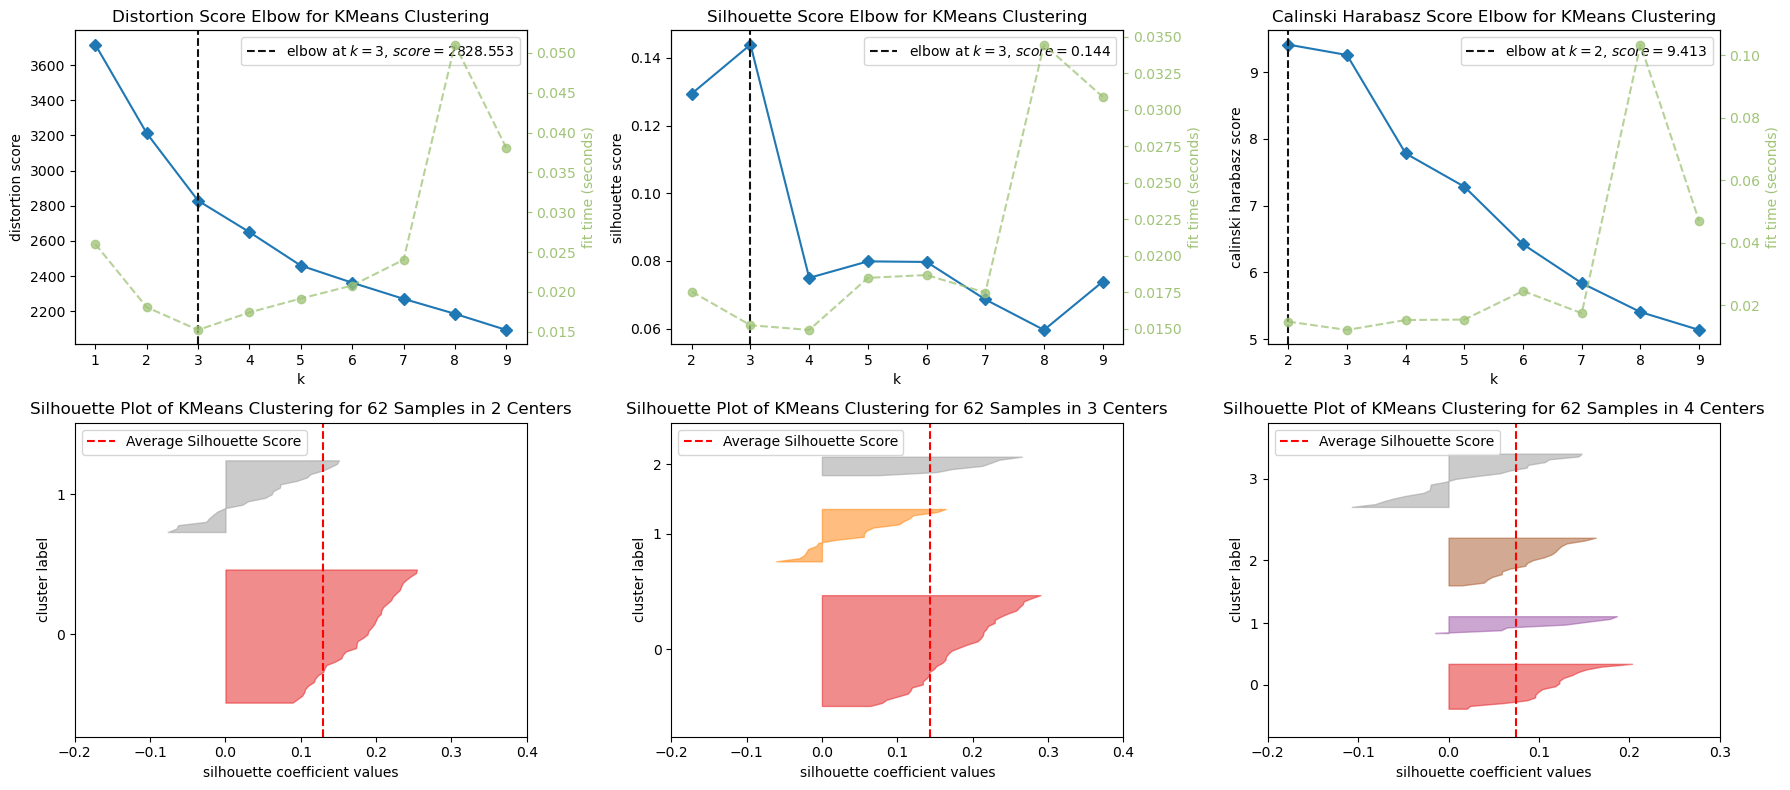

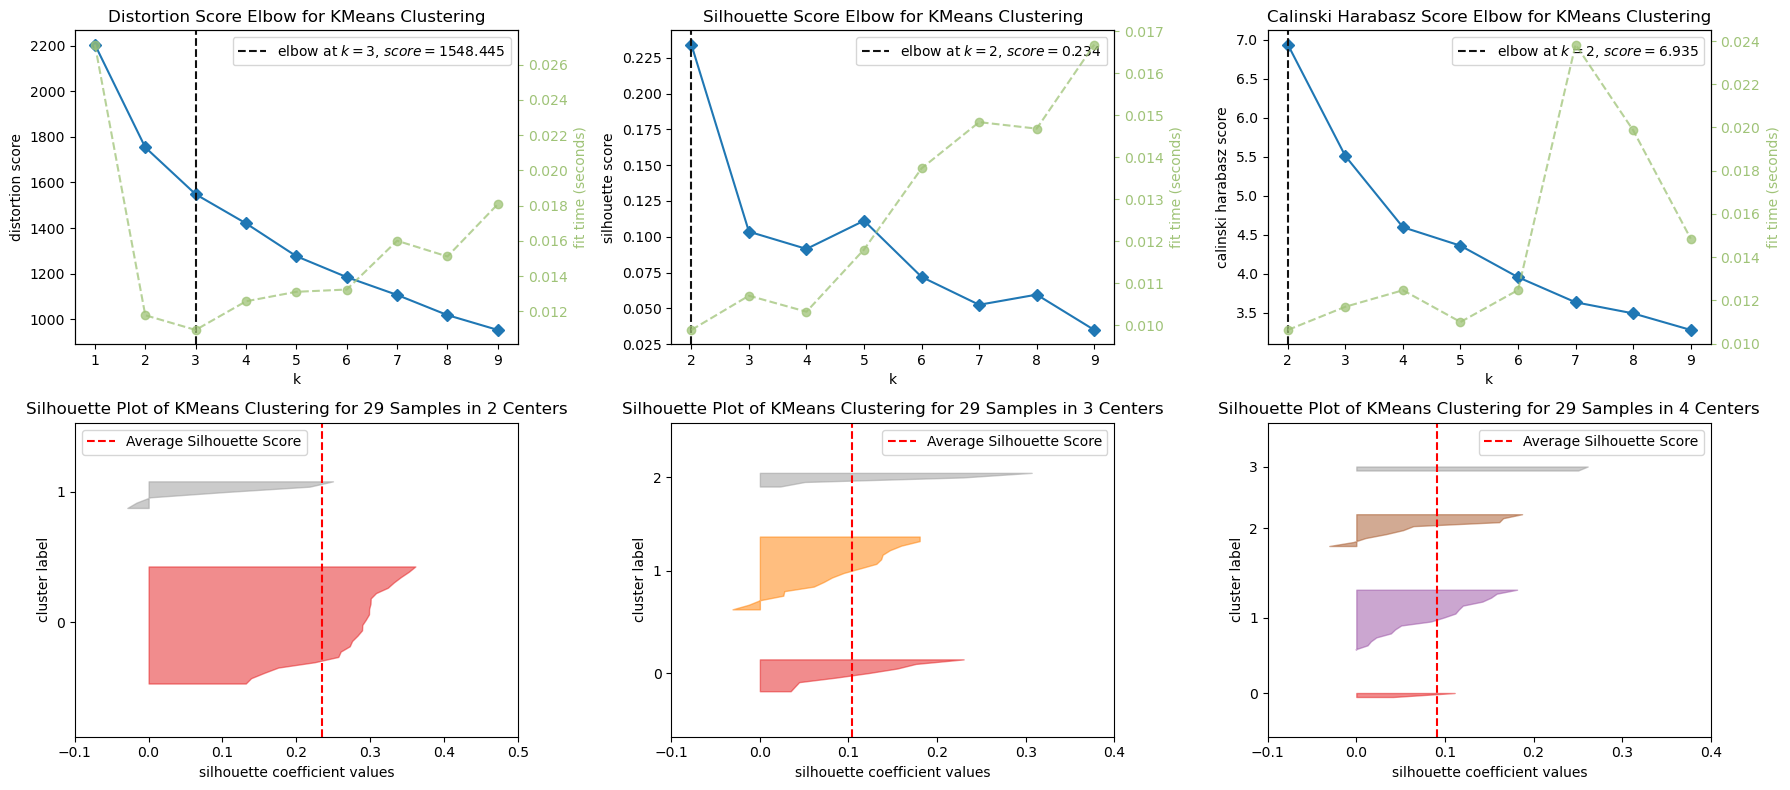

In [18]:
plot_elbow_sil(guards_df)  # GUARDS
plot_elbow_sil(wings_df)  # WINGS
plot_elbow_sil(forwards_df)  # FORWARDS
plot_elbow_sil(bigs_df)  # BIGS

Clustering algorithms such as K-Means require the 'k' value (number of clusters) to be specified a priori. As this can be a somewhat naive process, Elbow plots are commonly used to determine the optimal number of clusters to implement in an unsupervised clustering algorithm, by running several versions and evaluating an inflection point based on a given metric. The inflection point of the curve is regarded as the point at which the model is fit best at that corresponding number of clusters. The "arm" could be up or down while looking for an inflection point, as its dependent upon the metric plotted on the y-axis (whether an increase indicates better clustering or not). ***KElbowVisualizer*** module offers three different metrics to explore Elbow plots:

- **Distortion method**: looks at the sum of squared distances from each point to its assigned center, averaged out by k (minimum of k=1)
- **Silhouette method**: mean ratio of distances calculated within cluster and the distance to nearest cluster, averaged out by k (minumum of k=2)
- **Calinski_harabasz method**: computes the ratio of dispersion between and within clusters, averaged out by k (minimum of k=2)

The traditional metric used for the elbow method is the sum of squared distances for within clusters, which is depicted from the distortion score of the first plot above. The goal of the elbow method with this metric is to pick a 'k' that reduces the variances of data points within a cluster (to the center) as much as possible. The tradeoff of increasing the number of clusters, however, is the increase in time complexity as also plotted above, and the risk of overfitting the model which might result in clusters that are not be representative of other data. Based on the guards data, 3-4 clusters seems most ideal based on the elbow-plots. Although there were some mixed results, the dropoff from 3 to 4 isn't too substantial for the Silhouette and Calinski-Haribasz methods. For the wings data, the traditional elbow plot based on the distortion score shows 4 clusters again. However, this time there is a substantial dropoff for the other metrics. 3 clusters seems ideal based on the elbow plots for the forwards and bigs data. To build more confidence in these selections, we can further examine silhouette plots to gain some other insights about clustering the available data before execution.

Although plotting an elbow curve through the distortion method is the common approach to find an ideal *k*, silhouette plots can serve as an alternative, especially when the data itself is not very clustered. Unlike the traditional elbow metric, silhouette scoring takes into account the variance and skewness of the data as well. Common inspections done on these plots, in search of an optimal *k*, include checking if each silhouette falls over the average score line, its respective sizes to assess the density of the clusters, and the widths to assess separation between them. From the plots above, we can assess the silhouette coefficient values for each possible 'k' clusters, as well as, look at the density and separation between each cluster. The coefficient calculation involves finding the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. So if a score is negative, that indicates possible mistake in clustering, whereas a positive score indicates better separation. Based on this, we can assess if the clusters seem imbalanced, grouped well. To that extent, the guards data showed further mixed results for the silhouette plots. Although k=2 had the most homogenous silhouettes, the actual coefficient was the lowest here. On the flip side, k=3 had a diverse set of silhouettes with ton of negative spikes, but with the highest coefficient. The pattern was completely different for the wings data as k=2 had uneven silhoeuttes but a substantially higher coefficient. The forwards data showed the most consistent results across the various examinations as k=3 seems to be the most ideal. The bigs data, however, was murky again as k=2 had a higher silhouette score but less homogenous clusters.

Based on all of the above examinations and the explained considerations, the following was chosen for *k* for each dataset:
- Guards: 4
- Wings: 4
- Forwards: 3
- Bigs: 3

## 4C: Cluster Analysis

**Objective:** Execute and evaluate baseline cluster models.

---

#### Define a helper function to standardize clustering process for all datasets:

In [19]:
def exec_eval_cls(df, k, rs=42):
    """Executes baseline clustering algorithms based on given parameters and evaluates amonst relavant metrics."""
    
    # K-MEANS CLUSTERING
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=rs)  
    kmeans_cls = kmeans.fit_predict(df) + 1  # start cluster labels with 1

    # SPECTRAL CLUSTERING
    spec = SpectralClustering(n_clusters=k, random_state=rs)  
    spec_cls = spec.fit_predict(df) + 1

    # BIRCH 
    birch = Birch(threshold=0.01, n_clusters=k)
    birch_cls = birch.fit_predict(df) + 1

    # Gausian Mixture 
    gaus = GaussianMixture(n_components=k)
    gaus_cls = gaus.fit_predict(df) + 1
        
    # Evaluate using metrics typically used for clustering algorithms
    clusters = {'KMeans':kmeans_cls, 'Spectral':spec_cls, 'Birch':birch_cls, 'Gaussian-Mixture':gaus_cls}
    res = []
    for alg, cls_res in clusters.items():
        sil = round(silhouette_score(df, cls_res, metric='euclidean'), 2)  # compute silhouette_score
        chs = round(calinski_harabasz_score(df, cls_res), 2) # compute calinski_harabasz_score
        dbs = round(davies_bouldin_score(df, cls_res), 2) # compute davies_bouldin_score
        res.append([alg, sil, chs, dbs])
    
    # Prepare output dataframes
    results_df = pd.DataFrame(res, columns=['Algorithm', 'Silhouette-Score', 'Calinski-Haribasz' ,'Davies-Bouldin'])    
    
    return kmeans_cls, spec_cls, birch_cls, gaus_cls, results_df

def print_val_cnt(cls_list):
    """Outputs unique value counts for each cluster prediction set."""
 
    preds = {'KM': cls_list[0], 'Spec': cls_list[1], 'Birch': cls_list[2], 'Gaus': cls_list[3]}

    for i, j in preds.items():
        unique, counts = np.unique(j, return_counts=True)
        print(i, '\n', np.asarray((unique, counts)).T, '\n')

The function above constructs various clustering models and evaluates the results using common metrics to evaluate clustering models when there is no "ground-truth" label. These metrics use information in the dataset to evaluate the effectiveness of the clustering algorithm. The Silhouette Coefficient gives us a way to measure how similar each point is to its corresponding cluster compared to other clusters (value of 0 indicates high overlap). The **Calinski-Harabsz Index** compares is a ratio of dispersion within a cluster to the dispersion between clusters.  The **Davies-Bouldin Index** measures the average similarity measure of each cluster with its most similar cluster (value of 0 indicates no similarity). Because these scores rely at least partially on distances, we cannot compare the performance of an algorithm on the original and PCA datasets with these metrics. These metrics are all independent of the true value of the cluster labels (the permutation of labeling doesn't impact the computation of these metrics) -- making them reliable methods in cluster evaluations. 

Next, this function will be executed for each dataset and assessed to determine which clustered results to use. 

In [20]:
gc, wc, fc, bc = 4, 4, 4, 3

#### Cluster Guards data:

In [21]:
g_kmeans_cls, g_spec_cls, g_birch_cls, g_gaus_cls, g_results_df= exec_eval_cls(pca_guards_df, gc)
g_results_df

Algorithm  Silhouette-Score  Calinski-Haribasz  Davies-Bouldin
0            KMeans              0.15              15.49            1.75
1          Spectral              0.08               7.42            0.81
2             Birch              0.12              12.25            1.77
3  Gaussian-Mixture              0.10              11.15            2.32

In [22]:
print_val_cnt([g_kmeans_cls, g_spec_cls, g_birch_cls, g_gaus_cls])

KM 
 [[ 1 24]
 [ 2 26]
 [ 3 45]
 [ 4  3]] 

Spec 
 [[ 1 93]
 [ 2  1]
 [ 3  2]
 [ 4  2]] 

Birch 
 [[ 1 23]
 [ 2 15]
 [ 3 58]
 [ 4  2]] 

Gaus 
 [[ 1 52]
 [ 2 30]
 [ 3 13]
 [ 4  3]] 



The ideal cluster model has a minimized Davies-Bouldin score and maximized Silhouette and Calinski-Haribasz values. Based on above results, KMeans model seems to performed best in two of these metrics while having the second best score in the third. Looking closer at the cluster label distributions, labels 1-3 are fairly large for Kmeans model while label 4 only consists of a few players.

#### Cluster Wings data:

In [23]:
w_kmeans_cls, w_spec_cls, w_birch_cls, w_gaus_cls, w_results_df= exec_eval_cls(pca_wings_df, wc)
w_results_df

Algorithm  Silhouette-Score  Calinski-Haribasz  Davies-Bouldin
0            KMeans              0.19              10.40            1.24
1          Spectral              0.55               9.08            0.30
2             Birch              0.22               9.53            0.99
3  Gaussian-Mixture              0.18               9.18            1.23

In [24]:
print_val_cnt([w_kmeans_cls, w_spec_cls, w_birch_cls, w_gaus_cls])

KM 
 [[ 1 16]
 [ 2  1]
 [ 3 12]
 [ 4  6]] 

Spec 
 [[ 1 34]
 [ 2  1]] 

Birch 
 [[ 1 25]
 [ 2  5]
 [ 3  4]
 [ 4  1]] 

Gaus 
 [[ 1 12]
 [ 2  4]
 [ 3 18]
 [ 4  1]] 



Based on above results, Spectral model outputted the best Silhouette and Davies-Bouldin score. Although, it also had the worst Calinski-Haribasz score, this metric had close values among all the models. Therefore, Spectral seems to be the ideal model for the wings. However, this is slightly deceiving to look at without the context of the cluster label distribution, as it becomes immediately apparent that the Spectral model only clustered the data into 2 groups, rather than the specified hyperparameter. Based on this, Birch model seems to be the most ideal, as it also had comparatively better results.

#### Cluster Forwards data:

In [25]:
f_kmeans_cls, f_spec_cls, f_birch_cls, f_gaus_cls, f_results_df= exec_eval_cls(pca_forwards_df, fc)
f_results_df

Algorithm  Silhouette-Score  Calinski-Haribasz  Davies-Bouldin
0            KMeans              0.16              12.31            1.57
1          Spectral              0.10               7.32            1.30
2             Birch              0.13              11.79            1.80
3  Gaussian-Mixture              0.18              11.76            1.35

In [26]:
print_val_cnt([f_kmeans_cls, f_spec_cls, f_birch_cls, f_gaus_cls])

KM 
 [[ 1  3]
 [ 2 22]
 [ 3 20]
 [ 4 17]] 

Spec 
 [[ 1 40]
 [ 2  1]
 [ 3 20]
 [ 4  1]] 

Birch 
 [[ 1 12]
 [ 2 24]
 [ 3  6]
 [ 4 20]] 

Gaus 
 [[ 1 36]
 [ 2 10]
 [ 3 15]
 [ 4  1]] 



Spectral results are slightly deceiving again here. However, KMeans holds up the best across all the metrics without sacrificing cluster densities.

#### Cluster Bigs data:

In [27]:
b_kmeans_cls, b_spec_cls, b_birch_cls, b_gaus_cls, b_results_df= exec_eval_cls(pca_bigs_df, bc)
b_results_df

Algorithm  Silhouette-Score  Calinski-Haribasz  Davies-Bouldin
0            KMeans              0.17               8.89            1.50
1          Spectral              0.21               7.28            1.20
2             Birch              0.15               8.40            1.51
3  Gaussian-Mixture              0.26               8.53            1.25

In [28]:
print_val_cnt([b_kmeans_cls, b_spec_cls, b_birch_cls, b_gaus_cls])

KM 
 [[ 1  4]
 [ 2 13]
 [ 3 12]] 

Spec 
 [[ 1 22]
 [ 2  4]
 [ 3  3]] 

Birch 
 [[ 1 12]
 [ 2  5]
 [ 3 12]] 

Gaus 
 [[ 1  5]
 [ 2 20]
 [ 3  4]] 



Based on the scoring metrics, Spectral model seems to be the most ideal, despite the fairly uneven groupings. Kmeans also outputted comparatively decent results. Since the cluster densities are fairly similar, Spectral is the choice here.

#### Examine the clusters through visual techniques:

In [29]:
def plt_cls(df, labels, title, f1='PCA0', f2='PCA1', f3='PCA2'):
    """Examines clusters on a 3-D scale, using the first three principal components."""
    
    fig = px.scatter_3d(df, x=f1, y=f2, z=f3, symbol=labels,color=labels, title=f'K-Means Clusters on PCA Components for {title}') 
    
    camera = dict(up=dict(x=1, y=1, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=1.5, y=1.5, z=0.5))
    fig.update_layout(width=800, height=800, font_size=10, scene_camera=camera)
    fig.update_coloraxes(showscale=False)
    fig.show()
    return


In [30]:
plt_cls(pca_guards_df, g_kmeans_cls, 'Guards')
plt_cls(pca_wings_df, w_kmeans_cls, 'Wings')
plt_cls(pca_forwards_df, f_kmeans_cls, 'Forwards')
plt_cls(pca_bigs_df, b_kmeans_cls, 'Bigs')

Above, the clusters for each position group is visualized on a 3-D level. Although the function was built to handle any desired input components, the default of PCA1, PCA2, PCA3 were used, as they makeup about _ of the explained variance in the guards, wings, forwards, bigs sub-datasets respectively. Due to the large number of components themselves, it is hard to get a clear understanding of why two players would be grouped together based on just a subset of the feature set, which is important to keep in mind while making examinations above. Overall, the clusters seem to have parsed players based on their styles and production, which was the ideal objective of applying unsupervised techniques, in order to create a feature set for the supervised modeling. 

## 4D: Supervised-Modeling Pre-Requisites

**Objective:** Execute any necessary pre-processing steps and pre-requisite supervised ML techniques to prepare for modeling.

---

#### Encode cluster labels to prepare for modeling:

In [31]:
# g_cls, w_cls, f_cls, b_cls = g_kmeans_cls, w_birch_cls, f_kmeans_cls, b_spec_cls
g_cls, w_cls, f_cls, b_cls = g_kmeans_cls, w_kmeans_cls, f_kmeans_cls, b_kmeans_cls

In [32]:
### Guards
g_cls_df = pd.DataFrame(g_cls, columns=['g_cls'], dtype='category').set_index(guards_df.index)
g_cls_df = pd.get_dummies(g_cls_df)

### Wings
w_cls_df = pd.DataFrame(w_cls, columns=['w_cls'], dtype='category').set_index(wings_df.index)
w_cls_df = pd.get_dummies(w_cls_df)

### Forwards
f_cls_df = pd.DataFrame(f_cls, columns=['f_cls'], dtype='category').set_index(forwards_df.index)
f_cls_df = pd.get_dummies(f_cls_df)

### Bigs
b_cls_df = pd.DataFrame(b_cls, columns=['b_cls'], dtype='category').set_index(bigs_df.index)
b_cls_df = pd.get_dummies(b_cls_df)

#### Compile cluster data for all players:

In [33]:
# Create common columns for each dataframe
col_order = g_cls_df.columns.tolist() + w_cls_df.columns.tolist() + f_cls_df.columns.tolist() + b_cls_df.columns.tolist()  # common cols
g_cls_df[list(set(col_order) - set(g_cls_df.columns.tolist()))] = 0
w_cls_df[list(set(col_order) - set(w_cls_df.columns.tolist()))] = 0
f_cls_df[list(set(col_order) - set(f_cls_df.columns.tolist()))] = 0
b_cls_df[list(set(col_order) - set(b_cls_df.columns.tolist()))] = 0

# Combine data
player_clusters_df = pd.concat([g_cls_df, w_cls_df, f_cls_df, b_cls_df], axis=0, ignore_index=False).reindex(columns=col_order)
player_clusters_df.to_csv('cln_clusters.csv')
player_clusters_df

g_cls_1  g_cls_2  g_cls_3  g_cls_4  w_cls_1  \
PLAYER                                                                  
Nickeil Alexander-Walker        1        0        0        0        0   
Grayson Allen                   0        1        0        0        0   
Cole Anthony                    0        0        1        0        0   
LaMelo Ball                     0        0        1        0        0   
Lonzo Ball                      1        0        0        0        0   
...                           ...      ...      ...      ...      ...   
Jalen Smith                     0        0        0        0        0   
Isaiah Stewart                  0        0        0        0        0   
Karl-Anthony Towns              0        0        0        0        0   
Myles Turner                    0        0        0        0        0   
Robert Williams III             0        0        0        0        0   

                          w_cls_2  w_cls_3  w_cls_4  f_cls_1  f_cls_2  \
PLAYER                                                                  
Nickeil Alexander-Walker        0        0        0        0        0   
Grayson Allen                   0        0        0        0        0   
Cole Anthony                    0        0        0        0        0   
LaMelo Ball                     0        0        0        0        0   
Lonzo Ball                      0        0        0        0        0   
...                           ...      ...      ...      ...      ...   
Jalen Smith                     0        0        0        0        0   
Isaiah Stewart                  0        0        0        0        0   
Karl-Anthony Towns              0        0        0        0        0   
Myles Turner                    0        0        0        0        0   
Robert Williams III             0        0        0        0        0   

                          f_cls_3  f_cls_4  b_cls_1  b_cls_2  b_cls_3  
PLAYER                                                                 
Nickeil Alexander-Walker        0        0        0        0        0  
Grayson Allen                   0        0        0        0        0  
Cole Anthony                    0        0        0        0        0  
LaMelo Ball                     0        0        0        0        0  
Lonzo Ball                      0        0        0        0        0  
...                           ...      ...      ...      ...      ...  
Jalen Smith                     0        0        0        1        0  
Isaiah Stewart                  0        0        0        0        1  
Karl-Anthony Towns              0        0        1        0        0  
Myles Turner                    0        0        0        1        0  
Robert Williams III             0        0        0        0        1  

[224 rows x 15 columns]

#### Input cluster information into lineup data:

In [34]:
def check_exist(lineup):
    """Outputs boolean for whether the lineup consists of players within the available data."""
    
    names = lineup.split(', ')
    for name in names:
        if name not in player_clusters_df.index:
            return False
    return True

# Remove lineup info if lineup contains player that was filtered out from statistical data
lineup_df['filt'] = lineup_df.Lineups.map(check_exist)
lineup_df = lineup_df[lineup_df.filt == True].drop(columns=['filt']).reset_index(drop=True) 

In [35]:
def incorp_cls(df):
    """Returns cluster group label info for each input lineup."""
    
    names = df.Lineups.split(', ')
    cls_info = player_clusters_df.loc[names].values.sum(axis=0)
    return cls_info

lineup_df[player_clusters_df.columns] = lineup_df.apply(incorp_cls, axis='columns', result_type='expand')
# lineup_df

#### Feature engineer to set up an alternative classification problem:

In [36]:
lineup_df['plus_rtg'] = lineup_df.NetRtg.map(lambda x: 0 if x <0 else 1)
# lineup_df['plus_rtg'] = lineup_df.NetRtg.map(lambda x: -1 if x < -5 else 0 if x < 5 else 1)
# lineup_df['plus_rtg'] = lineup_df.NetRtg.map(lambda x: 0 if x < 5 else 1)

#### Conduct a brief feature-selection investigation for the regression & classification problem:

In [37]:
def ft_sel_inv(prob_type, tgt_var_name):
    """Evaluates features, based on input metrics, to assess which will be most useful in a supervised problem."""
    
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    
    if prob_type == 'reg':
        feature_selectors = {
            0: [f_regression, 'f_value (transformed from correlations)', f'Feature Selection with f_regression for {tgt_var_name}'], 
            1: [mutual_info_regression, 'Estimated MI Value', f'Feature Selection with Mutual Info Regression for {tgt_var_name}']
        }
    else: 
        feature_selectors = {
        0: [f_classif, 'KBest score for f_classif', f'Feature Selection with ANOVA F-Value for {tgt_var_name}'], 
        1: [mutual_info_classif, 'Estimated MI Value', f'Feature Selection with Mutual Info Classification for {tgt_var_name}']
    }

    for i in range(2):
        # Learn relationship from data
        f_sel = SelectKBest(score_func=feature_selectors[i][0], k='all').fit(lineup_df[player_clusters_df.columns.tolist()], lineup_df[tgt_var_name])
        # Transform input data
        X_fs = f_sel.transform(lineup_df[player_clusters_df.columns.tolist()])
        # Plot score for each feature
        sns.barplot(x=f_sel.scores_, y=player_clusters_df.columns.tolist(), orient='h', ax=axs[i])
        axs[i].set_xlabel(feature_selectors[i][1])
        axs[i].set_title(feature_selectors[i][2])

    axs[0].set_ylabel('Features')
    plt.tight_layout()
    plt.show()
    return

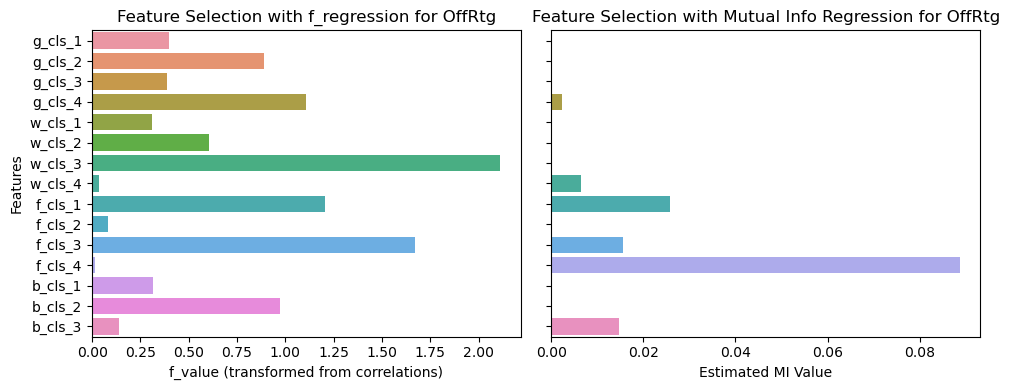

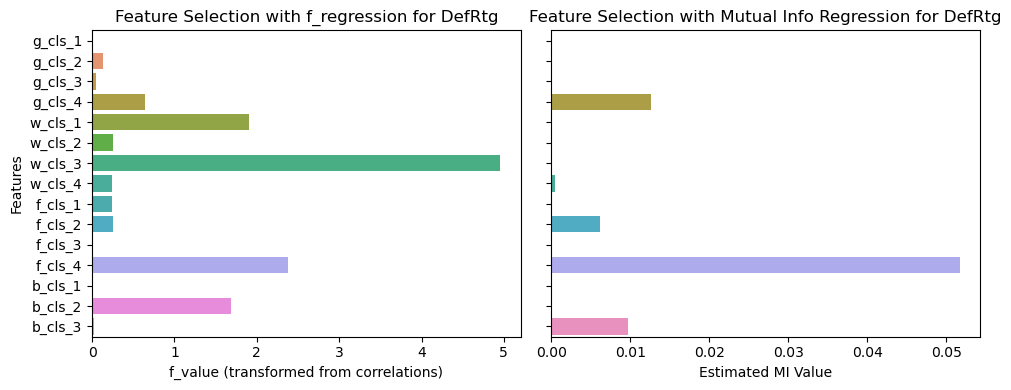

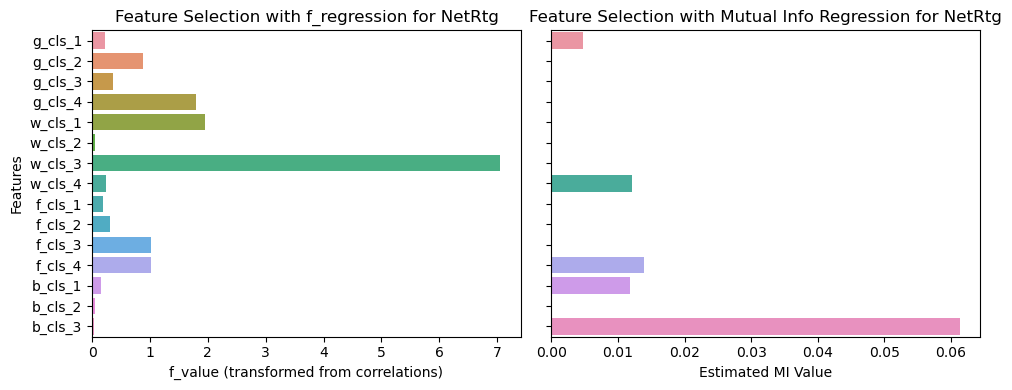

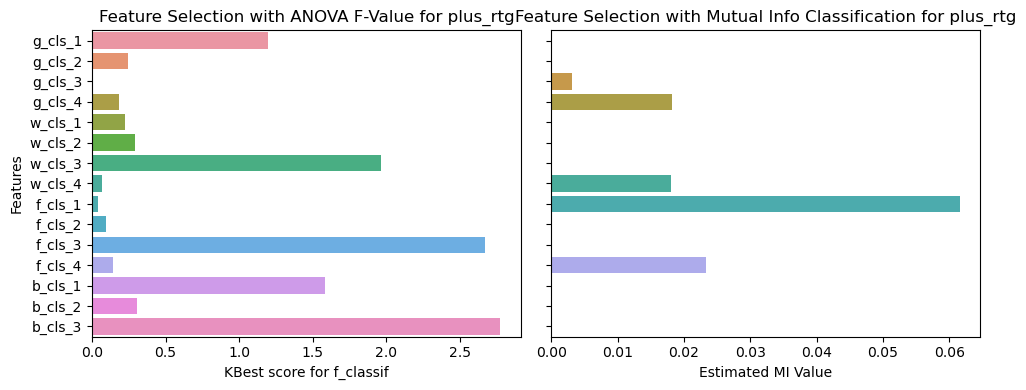

In [38]:
ft_sel_inv('reg', 'OffRtg')
ft_sel_inv('reg', 'DefRtg')
ft_sel_inv('reg', 'NetRtg')
ft_sel_inv('clf', 'plus_rtg')

For the regression problems, both metrics used for the feature selection investigation showed conflicting results on which attributes are the most meaninful towards building a model. However, one thing that was consistent was that the attribute patterns were different when the target variable is the offensive rating versus the defensive rating. Therefore, this study at least helps affirm that the best course of action for a regression problem is to execute a model for each offensive and defensive rating, to compute the estimated net rating, rather than using net rating as the target variable.

For the classification problem, the feature selection investigation showed more consistent results among the two metrics used. For each position, there was a particular cluster or two that seemed to determine if a lineup consisting of a player belonging to that cluster indicates a net-positive rating on the court. Wings-Cluster-3, Forwards-Cluster-3, and Bigs-Cluster-3 seemed to be the most important.

In [39]:
lineup_df.to_csv('cln_train.csv')

## 4E: Supervised-Modeling: Regression

**Objective:** In this section, few baseline regression algorithms are implemented, tuned, and analyzed using the feature-set created from unsupervised modeling.

---

#### Setup a streamlined process to execute and evaluate baseline regression models: 

In [40]:
def fit_model(model, x_data, y, table):
    """Constructs a given model based on input data and evaluates results among relevant metrics."""
    
    model = model.fit(x_data, lineup_df[y].values)
    pred = model.predict(x_data)
    r2 = round(r2_score(lineup_df[y].values, pred), 2)
    mae = round(mean_absolute_error(lineup_df[y].values, pred), 2)
    rmse = round(np.sqrt(mean_squared_error(lineup_df[y].values, pred)), 2)
    medae = round(median_absolute_error(lineup_df[y].values, pred), 2)  
    mape = round(mean_absolute_percentage_error(lineup_df[y].values, pred),2) 
    table.add_row([model, y, r2, mae, rmse, medae, mape])
    return table

def exec_regr(target, rs=42):
    """Executes streamlined-process using the input target variable."""
    
    # Define set of baseline models to iterate through
    models = [
        LinearRegression(),
        DecisionTreeRegressor(random_state=rs),
        RandomForestRegressor(random_state=rs),
        Lasso(random_state=rs),
        ElasticNet(random_state=rs),
        Ridge(random_state=rs),
        SVR()
    ]

    # Instantiate a tabular structure to store results from each model
    table = PrettyTable()
    table.field_names = ['Model', 'Target', 'R2', 'MAE', 'RMSE', 'MedAE', 'MAPE']
    
    # Execute model
    for model in models:
        table = fit_model(model, lineup_df[player_clusters_df.columns.tolist()], target, table)

    return table

A variety of regressor estimators were chosen to model the data, ranging from linear-regression based algorithms (including `Lasso`/`Ridge`/`ElasticNet`) to support vector regressor to tree-based methods. 

The primary area where the linear-based regression techniques (standard `LinearRegression`, `Lasso`, `Ridge`, `ElasticNet`) differ is the penalization for weights assigned to the features. While the standard version has no penalities, Lasso aims to penalize based on sum of absolute values of weights and Ridge penalizes based on sum of squared weight values. 

On the other hand, tree-based regressors rely on a single tree (`DecisionTreeRegressor`) or an ensemble of trees (`RandomForestRegressor`) constructed from a set of binary splits of branches based on the satisfaction of attribute conditions that aim to reduce mean squared error with each split. A random forest algorithm aims that builds many random trees in parallel is especially known for its predictive capabilities but tree-based methods have a knack for overfitting data. 

In a Support Vector regressor (`SVR`), the algorithm aims to find a hyperplane (in the context of this dataset with 8 variables, it would be a plane in the 8-dimensional space) based on the "support vectors", or the data points closest to this plane. This essentially serves as a decision boundary that would be used to predict the continuous target variable. As this algorithm is known to suit smaller datasets and for being robust to outliers, `SVR` will also be implemented in this study. 

Exploring these diverse methods, and assessing the models based on relevant metrics can help further narrow down the suitable method that best represents this dataset.

The releveant metrics chosen to evaluate the diverse set of regression models are: R^2, Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Median Absolute Error (MedAE), and Mean Absolute Percentage Error (MAPE). Outlined below is a high-level overview on how to interpret these metrics and the context in which they are used, followed by a discussion of the results above: 

`R^2`: Higher R^2 value indicates that the model accounts for the variability of the dataset, while a lower value (usually) indicates a worse fit. The disadvantage of this metric is that the value never takes a negative impact with the addition of more features (even if it is a poor predictor). 

`MAE`: This metric is computed by simply averaging the absolute errors for each record (therefore, lower value indicates better predictability). This metric is often used in the case of outlier data.

`RMSE`: The square root of the mean squared error is taken to compute RMSE. The advantage of MSE and RMSE is that they are both differentiable functions, meaning they can be used in models that employ a loss-function in the algorithm. However, unlike MAE, this metric is not robust to outliers. 

`MedAE`: This is computed similar to MAE but uses median instead of mean, to make it even more robust to outliers. 

`MAPE`: In this version, percentages of the errors are used instead, also known for its robustness to outliers. 

#### Execute and evaluate baseline regression models:

In [41]:
print(exec_regr('OffRtg'))
print(exec_regr('DefRtg'))
print(exec_regr('NetRtg'))

+----------------------------------------+--------+------+-------+-------+-------+------+
|                 Model                  | Target |  R2  |  MAE  |  RMSE | MedAE | MAPE |
+----------------------------------------+--------+------+-------+-------+-------+------+
|           LinearRegression()           | OffRtg | 0.03 | 11.46 | 14.56 |  9.48 | 0.11 |
| DecisionTreeRegressor(random_state=42) | OffRtg | 0.71 |  4.8  |  8.01 |  1.05 | 0.05 |
| RandomForestRegressor(random_state=42) | OffRtg | 0.63 |  6.95 |  8.99 |  5.76 | 0.07 |
|         Lasso(random_state=42)         | OffRtg | 0.0  | 11.56 |  14.8 |  9.71 | 0.11 |
|      ElasticNet(random_state=42)       | OffRtg | 0.0  | 11.56 |  14.8 |  9.63 | 0.11 |
|         Ridge(random_state=42)         | OffRtg | 0.03 | 11.46 | 14.56 |  9.46 | 0.11 |
|                 SVR()                  | OffRtg | 0.05 | 11.12 | 14.45 |  8.49 | 0.11 |
+----------------------------------------+--------+------+-------+-------+-------+------+
+---------

From the results table, the tree-based moddels scored the "best" among the regression metrics used to evaluate the models (highest R^2 and lowest in others). However, it is very important to note here that tree-based algorithms such as decision trees are notoriously known to overfit. Therefore, the best possible scoring here doesn't necessarily translate to the model generalizing to new data. These scores were generated from a "baseline" version of each model and therefore, the tree-based techniques are explored further below.

#### Optimize the best performing regression models:

In [42]:
### Target: OffRtg

rs = 42
o_rf = RandomForestRegressor(random_state=rs, n_estimators=25, max_depth=10)
X_train, X_test, y_train, y_test = train_test_split(lineup_df[player_clusters_df.columns.tolist() + ['MIN']], lineup_df.OffRtg, test_size=0.2, random_state=42)
o_rf.fit(X_train.drop(columns=['MIN']), y_train, sample_weight=X_train.MIN)

o_train_pred = o_rf.predict(X_train.drop(columns=['MIN']))
o_test_pred = o_rf.predict(X_test.drop(columns=['MIN']))
print(mean_squared_error(y_train, o_train_pred))
print(mean_squared_error(y_test, o_test_pred))
print(r2_score(y_train, o_train_pred))
print(r2_score(y_test, o_test_pred))

106.92871974513687
261.1397214952992
0.4885352056124216
-0.02442171560468065


In [43]:
# resplt = ResidualsPlot(o_rf)
# resplt.fit(X_train.drop(columns=['MIN']), y_train).score(X_test.drop(columns=['MIN']), y_test)
# resplt.show()

# peplt = PredictionError(o_rf)
# peplt.fit(X_train.drop(columns=['MIN']), y_train).score(X_test.drop(columns=['MIN']), y_test)
# peplt.show()

# lc = LearningCurve(o_rf, scoring='r2', cv=5)
# lc.fit(X_train.drop(columns=['MIN']), y_train).score(X_test.drop(columns=['MIN']), y_test)
# lc.show()

# fi = FeatureImportances(o_rf)
# fi.fit(X_train.drop(columns=['MIN']), y_train).score(X_test.drop(columns=['MIN']), y_test)
# fi.show()

In [44]:
### Target: DefRtg

rs = 42
d_rf = RandomForestRegressor(random_state=rs, n_estimators=25, max_depth=10)
X_train, X_test, y_train, y_test = train_test_split(lineup_df[player_clusters_df.columns.tolist() + ['MIN']], lineup_df.DefRtg, test_size=0.2, random_state=42)
d_rf.fit(X_train.drop(columns=['MIN']), y_train, sample_weight=X_train.MIN)

d_train_pred = d_rf.predict(X_train.drop(columns=['MIN']))
d_test_pred = d_rf.predict(X_test.drop(columns=['MIN']))
print(mean_squared_error(y_train, d_train_pred))
print(mean_squared_error(y_test, d_test_pred))
print(r2_score(y_train, d_train_pred))
print(r2_score(y_test, d_test_pred))

79.8054326722107
290.25559892202057
0.6020381484495144
-0.08910767421475274


In [45]:
# resplt = ResidualsPlot(d_rf)
# resplt.fit(X_train.drop(columns=['MIN']), y_train).score(X_test.drop(columns=['MIN']), y_test)
# resplt.show()

# peplt = PredictionError(d_rf)
# peplt.fit(X_train.drop(columns=['MIN']), y_train).score(X_test.drop(columns=['MIN']), y_test)
# peplt.show()

# lc = LearningCurve(d_rf, scoring='r2', cv=5)
# lc.fit(X_train.drop(columns=['MIN']), y_train).score(X_test.drop(columns=['MIN']), y_test)
# lc.show()

# fi = FeatureImportances(d_rf)
# fi.fit(X_train.drop(columns=['MIN']), y_train).score(X_test.drop(columns=['MIN']), y_test)
# fi.show()

In [46]:
### Compute NetRtg prediction

n_train_pred = o_train_pred - d_train_pred
n_test_pred = o_test_pred - d_test_pred
X_train, X_test, y_train, y_test = train_test_split(lineup_df[player_clusters_df.columns.tolist() + ['MIN']], lineup_df.NetRtg, test_size=0.2, random_state=42)
print(mean_squared_error(y_train, n_train_pred))
print(mean_squared_error(y_test, n_test_pred))
print(r2_score(y_train, n_train_pred))
print(r2_score(y_test, n_test_pred))

169.65164801093255
551.3348135728788
0.5654752173685527
-0.05218580655501737


Both the regression models, for the offensive rating and defensive rating predictions, outputted fairly similar results for the mean squared error and r^2 score. Both performed acceptable on the training set and were underwhelming for the test set, indicating signs of overfitting which is common for tree-based methods. However, further tuning did not improve the fit for the models. In fact, validation curves for both models show that the score doesn't seem to improve at different levels of the hyperparameters. 

Furthermore, residuals and prediction errors were plotted for both models, as a tool to examine any signs of poor fit. Most interestingly, the feature importances showed the most surprising results. In contrast to the initial feature selection investigation, the most important clusters the model used in determining the ratings were for guards/forwards. This indicates that the guards and forwards of the lineup dictate how well that lineup performs the most.

Next, a classification study is setup, as an alternate means, to assess if that approach is better useable for this study.

## 4F: Supervised-Modeling: Classification

**Objective:** In this section, few baseline classification algorithms are implemented, tuned, and analyzed using the feature-set created from unsupervised modeling.

---

#### Conduct baseline classification modeling: 

In [47]:
models = [
    LogisticRegression(),
    RandomForestClassifier(random_state=42),
    SVC(random_state=42),
    KNeighborsClassifier(n_neighbors=3)
]

for model in models:
    model.fit(lineup_df[player_clusters_df.columns.tolist()], lineup_df.plus_rtg)
    pred = model.predict(lineup_df[player_clusters_df.columns.tolist()])
    print(model)
    print(classification_report(lineup_df.plus_rtg, pred))


LogisticRegression()
              precision    recall  f1-score   support

           0       0.56      0.31      0.40       123
           1       0.62      0.82      0.71       170

    accuracy                           0.61       293
   macro avg       0.59      0.57      0.55       293
weighted avg       0.60      0.61      0.58       293

RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.89      0.82      0.86       123
           1       0.88      0.93      0.90       170

    accuracy                           0.88       293
   macro avg       0.89      0.88      0.88       293
weighted avg       0.88      0.88      0.88       293

SVC(random_state=42)
              precision    recall  f1-score   support

           0       0.79      0.37      0.51       123
           1       0.67      0.93      0.78       170

    accuracy                           0.70       293
   macro avg       0.73      0.65      0.64   

Four different classification estimators were chosen to model the data, including a neighbors-distance based model similar to the unsupervised techniques.

`LogisticRegression` is a modified version of linear regression that uses a sigmoid function to account for the discrete categorical outcome variables. On the other hand, tree-based classifiers rely on a single tree (`DecisionTreeClassifier`) or an ensemble of trees (`RandomForestClassifier`) constructed from a set of binary splits of branches based on the satisfaction of attribute conditions that aim to reduce entropy (or improve information gain) with each split. A random forest algorithm aims that builds many random trees in parallel is especially known for its predictive capabilities but tree-based methods have a knack for overfitting data. 

In a Support Vector classifier (`SVC`), the algorithm aims to find a hyperplane (in the context, it would be a plane in the 20+-dimensional space) based on the "support vectors", or the data points closest to this plane. This essentially serves as a decision boundary that would be used to distinguish the binary categorical target variable. As this algorithm is known to suit smaller datasets and for being robust to outliers, its performance in this scenario with a mid-sized dataset and high dimensionality will be interesting to observe.

`KNeighborsClassifier` relies on the neighbors of a data point as the best classifier for a record. This is known as a "lazy learner" as the model itself isn't constructed till a prediction needs to be made. At this point, a distance metric is used to track each other point to the record that needs to be classified. The specified hyperparameter number of nearest neighbors are then selected to figure out how to best classify the data point of interest. In a classification scenario such as this, ties are broken usually through a random selection between most occuring target classes.

Based on the classification reports, the tree-based random forest outperformed all others once again and therefore will be tuned further.

#### Optimize the best performing classification model:

In [48]:
rs=42
rf = RandomForestClassifier(random_state=rs, n_estimators=25, max_depth=10)
lineup_df['rtg'] = lineup_df.NetRtg.map(lambda x: 0 if x <0 else 1)
lineup_df['rtg2'] = lineup_df.NetRtg.map(lambda x: -1 if x < -5 else 0 if x < 5 else 1)
# lineup_df['rtg2'] = lineup_df.NetRtg.map(lambda x: 0 if x < 5 else 1)
X_train, X_test, y_train, y_test = train_test_split(lineup_df[player_clusters_df.columns.tolist() + ['MIN']], lineup_df.plus_rtg, test_size=0.2, random_state=42)
rf.fit(X_train.drop(columns=['MIN']), y_train, sample_weight=None)

train_pred = rf.predict(X_train.drop(columns=['MIN']))
test_pred = rf.predict(X_test.drop(columns=['MIN']))
print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       103
           1       0.87      0.95      0.91       131

    accuracy                           0.89       234
   macro avg       0.90      0.88      0.89       234
weighted avg       0.89      0.89      0.89       234

              precision    recall  f1-score   support

           0       0.55      0.55      0.55        20
           1       0.77      0.77      0.77        39

    accuracy                           0.69        59
   macro avg       0.66      0.66      0.66        59
weighted avg       0.69      0.69      0.69        59



In [49]:
lineup_df.plus_rtg.value_counts()

1    170
0    123
Name: plus_rtg, dtype: int64

The random forest classifier was tuned further to optimized for accuracy. The classification report outputs evaluation metrics other than just accuracy. Other metrics include: precision, recall, f1. Outlined below is a high-level overview on how to interpret these metrics and the context in which they are used, followed by a discussion of the results above: 

`Accuracy`: Accuracy of classification predictions based on actual values is the standard metric, especially in the case of a fairly even proportion of classes in the target variable.

`Precision`: Precision/specificity is the proportion of correct *positive* predictions to the total *positive* predictions.

`Recall`: Recall/sensitivity is the proportion of correct *positive* predictions to the total number of positive records.

`F1`: The F1 score is the harmonic mean (therefore, penalizes extreme values) of precision and recall.

   Overall accuracy to evaluate a model makes sense when all classes (true positives, true negatives, false positives, false negatives) are equally important. However, if the costs of incorrect *positive* prediction is high, Precision is the better metric to use. If the costs of incorrect *negative* prediction is high, Recall is the better metric to use.
   
Above shows that the target value counts are imbalanced, albeit slightly. Therefore, it is important to account for all the evaluation metrics here. Most importantly, the results show that recall and precision score for class-1 observations are higher. In this context, this means that lineups designated as "net-positive" are less likely to be wrong then lineups designated as "negative". Although the evaluation metrics' scores are slightly underwhelming, there is consolation in the fact that the model has a fairly impressive record on lineups where it projects to be successful.

Apart from that, there are a few more important insights to draw from the modeling. The training set seemed to have performed impressively for both the regression and classification models. However, the models did not generalize as well to the test set. This was not mitigated through any grid search attempts either, pointing to other factors that could have impacted the study. Furthermore, another strategy that was used to bridge the gap between training and test results was to use sample_weights with the "weight" of each lineup trained based on the minutes played for that lineup. However, this did not impact the results either. 

Nonetheless, the models showed somewhat insightful results on the prowess of individual player stats in predicting a lineup's performance. There are many factors that weren't taken into consideration in this study that could also be affecting the results. This includes a team's playing scheme, lack of advanced stats, etc. that could perhaps be a stepping stone for a future improvement to this project.

#### Examine most important features for the classification model:

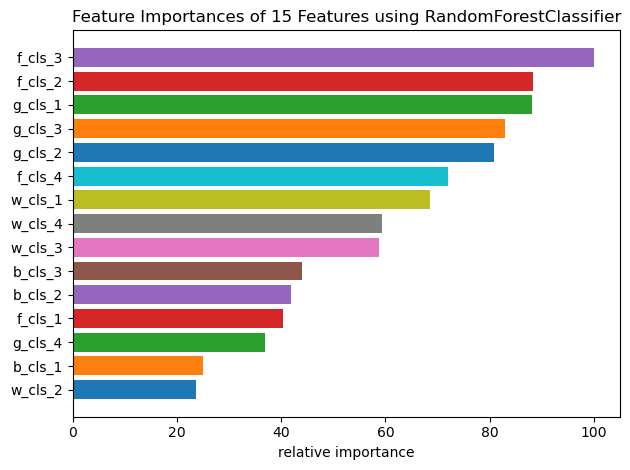

In [50]:
clf_fi = FeatureImportances(rf).fit(X_train.drop(columns=['MIN']), y_train).finalize()

Surprisingly, unlike the feature selection investigation, the most important groupings that the classifer looked at are for the forwards and guards. This means that the type of guard or forward that a lineup consists of impacts the performance of that lineup the most. This is a fairly insightful high-level observation that can be drawn from this study. 